In [12]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from statsmodels.tsa.arima.model import ARIMA

In [13]:
# Reading the file
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('top_50_stocks_data_formatted.csv')
df.head()

Saving top_50_stocks_data_formatted.csv to top_50_stocks_data_formatted (1).csv


Ticker        Date        Open       Close        High         Low  \
0   AAPL  2022-01-03  177.830002  182.009995  182.880005  177.710007   
1   AAPL  2022-01-04  182.630005  179.699997  182.940002  179.119995   
2   AAPL  2022-01-05  179.610001  174.919998  180.169998  174.639999   
3   AAPL  2022-01-06  172.699997  172.000000  175.300003  171.639999   
4   AAPL  2022-01-07  172.889999  172.169998  174.139999  171.029999   

   Adjusted Close     Volume  
0      179.481110  104487900  
1      177.203217   99310400  
2      172.489609   94537600  
3      169.610214   96904000  
4      169.777847   86709100

In [14]:
# Null values
df.isnull().sum()

Ticker            0
Date              0
Open              0
Close             0
High              0
Low               0
Adjusted Close    0
Volume            0
dtype: int64

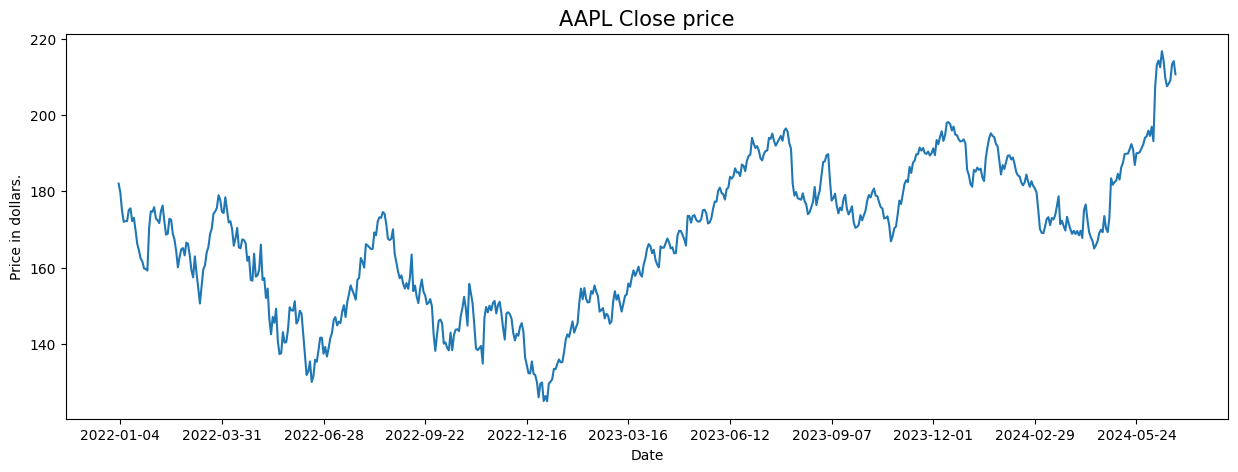

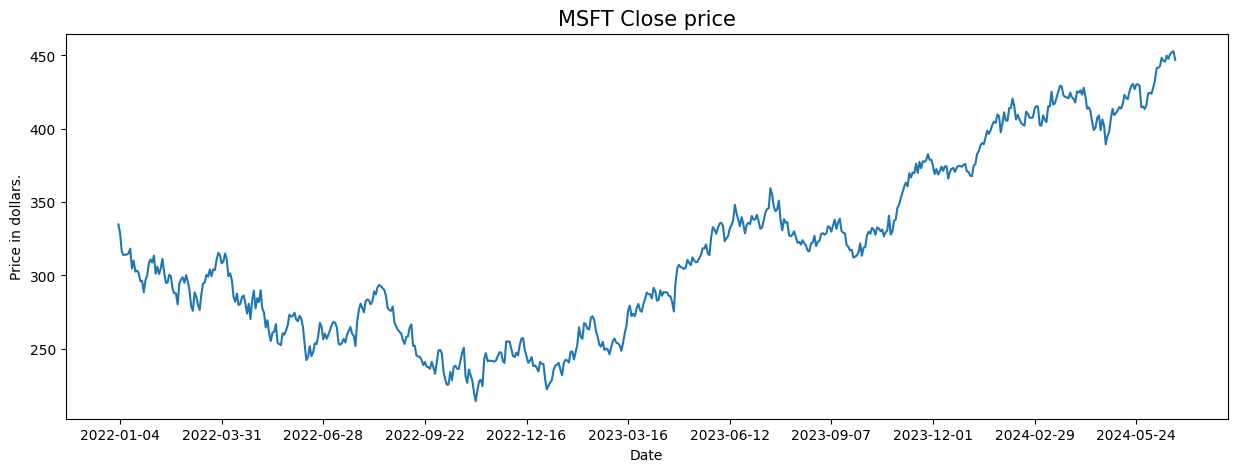

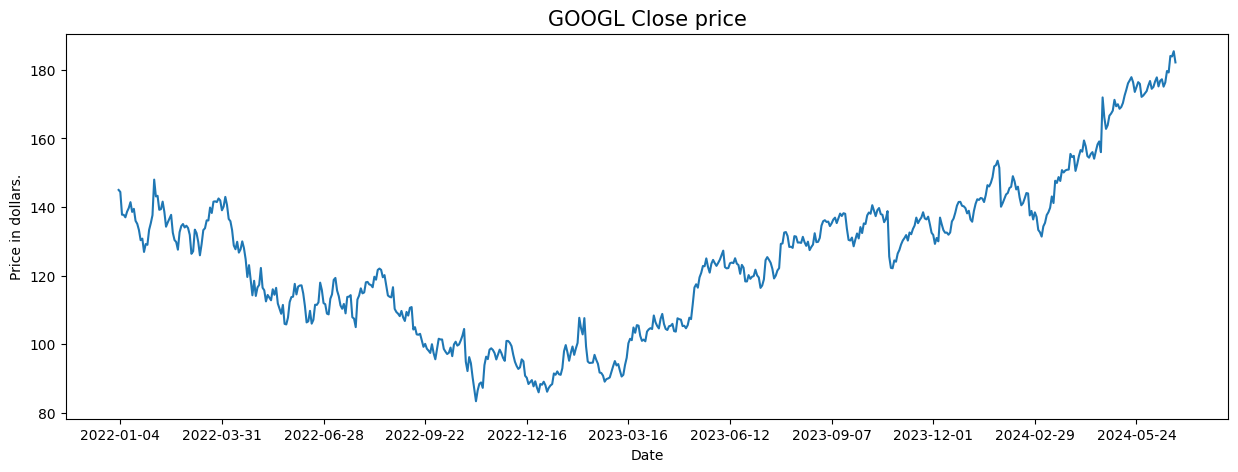

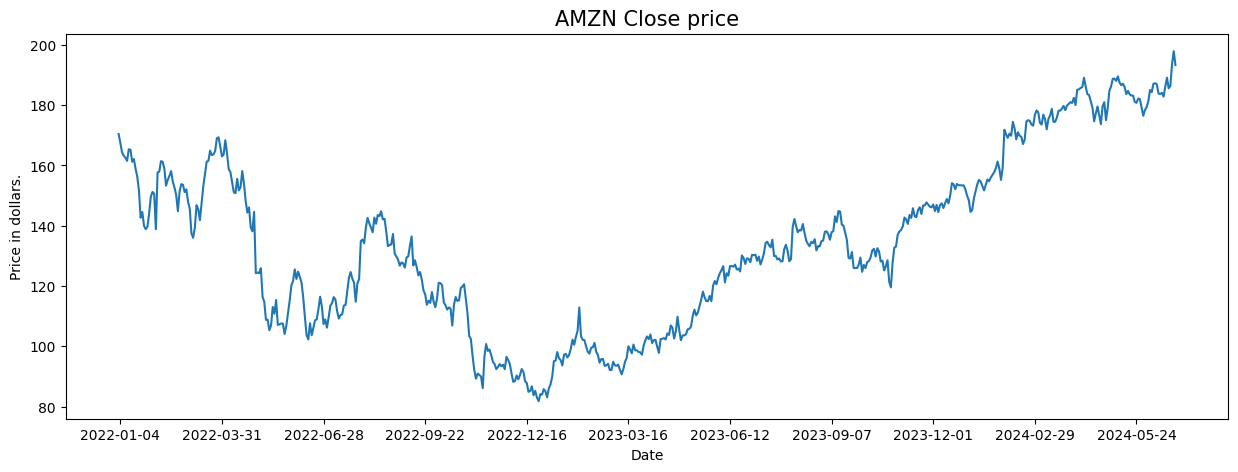

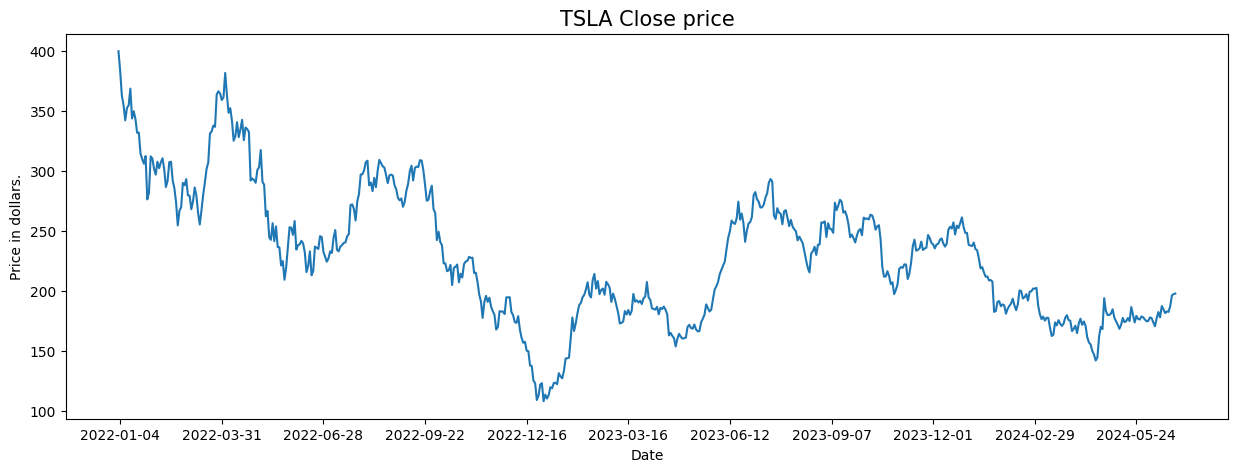

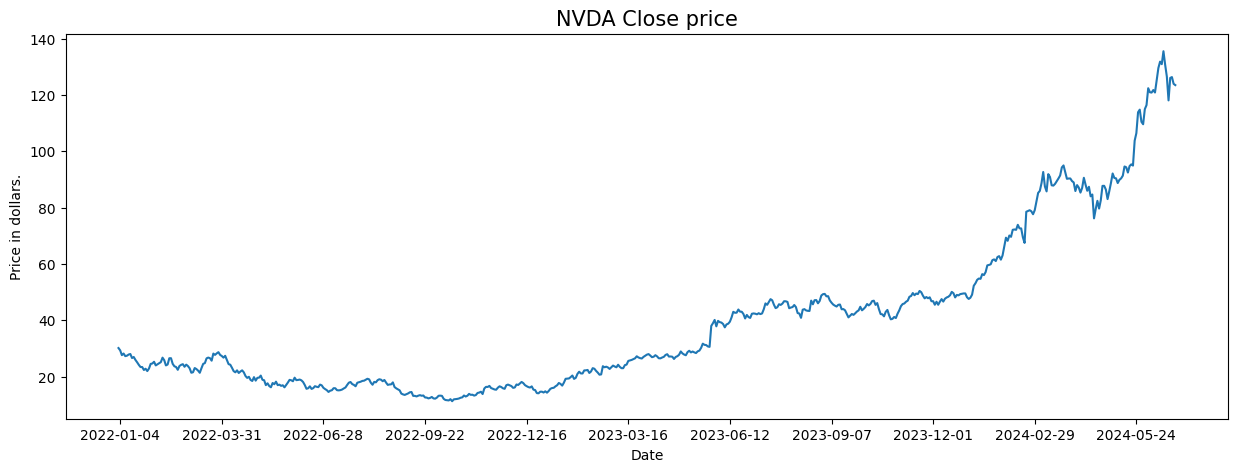

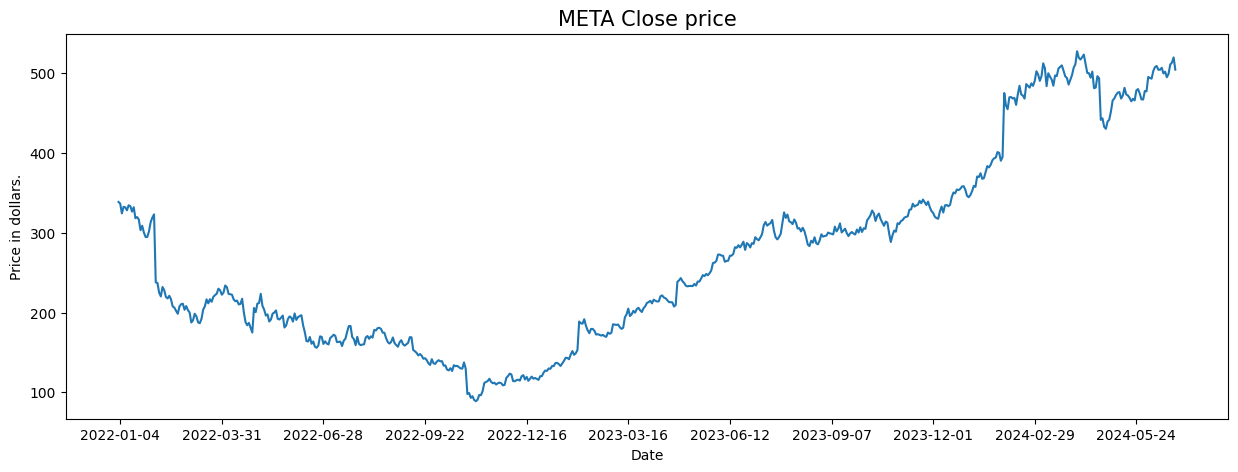

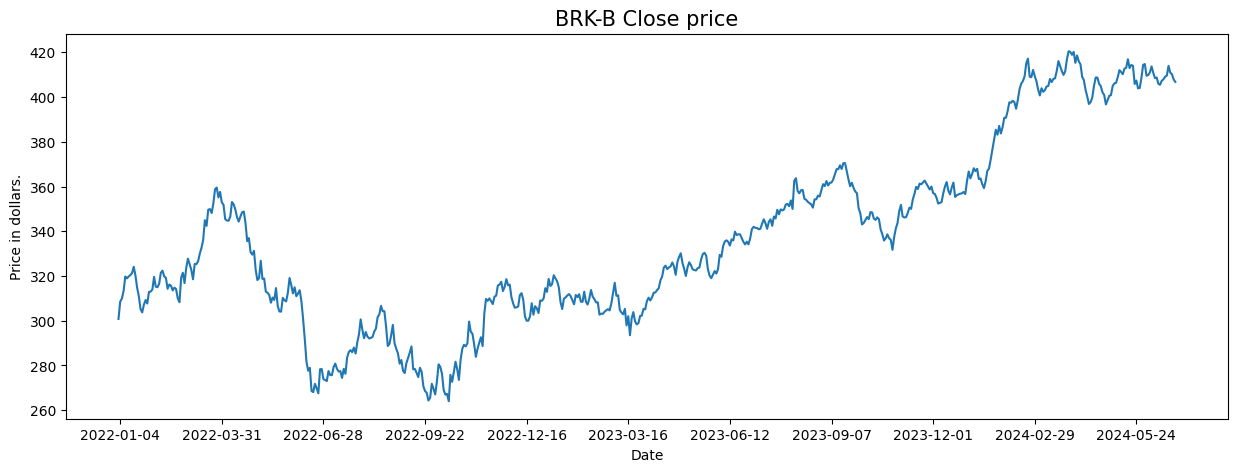

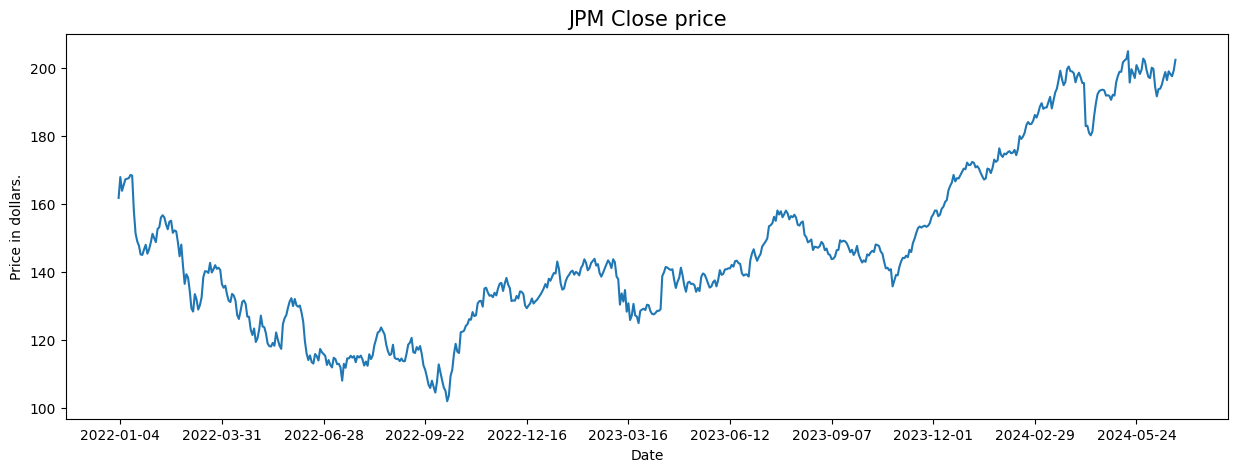

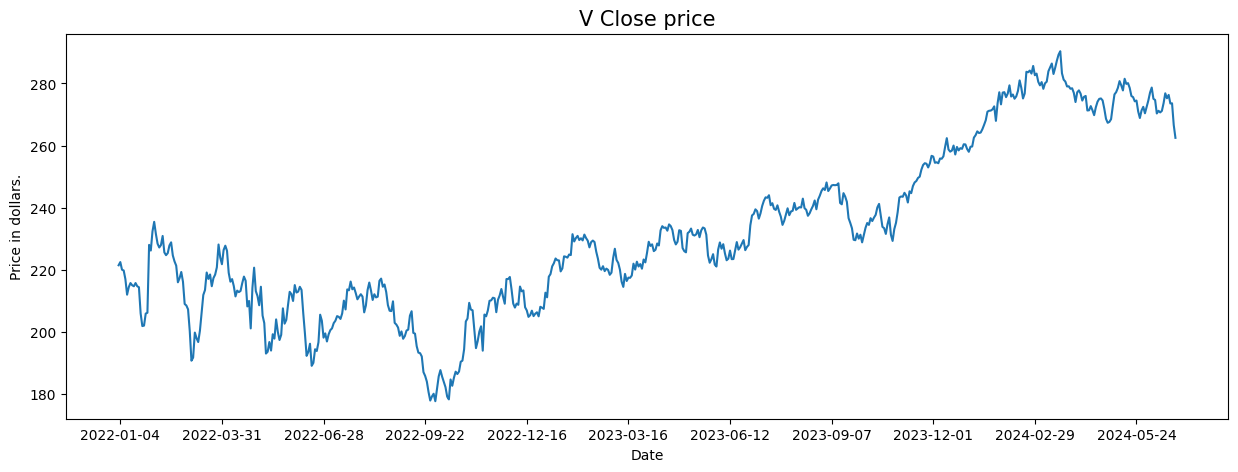

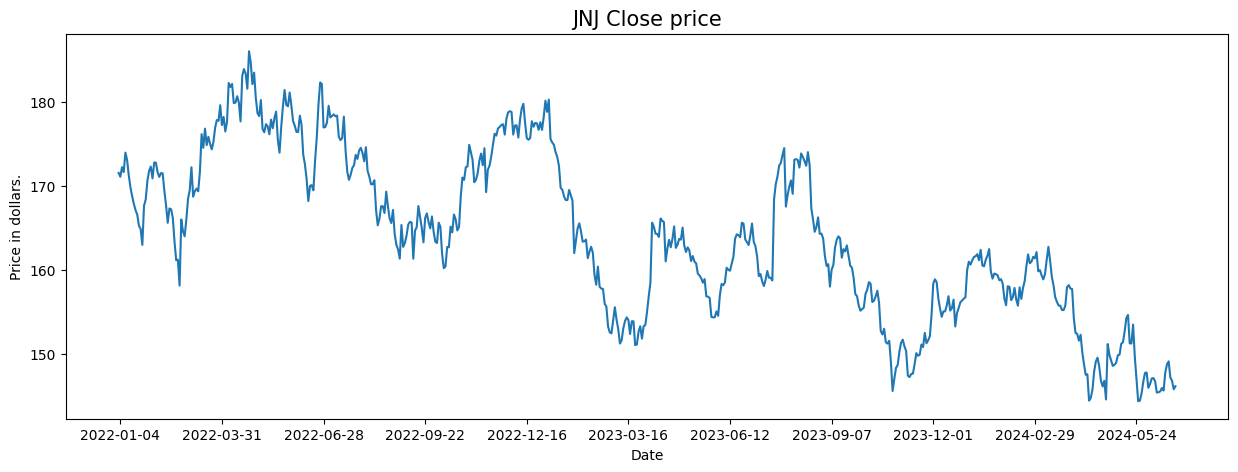

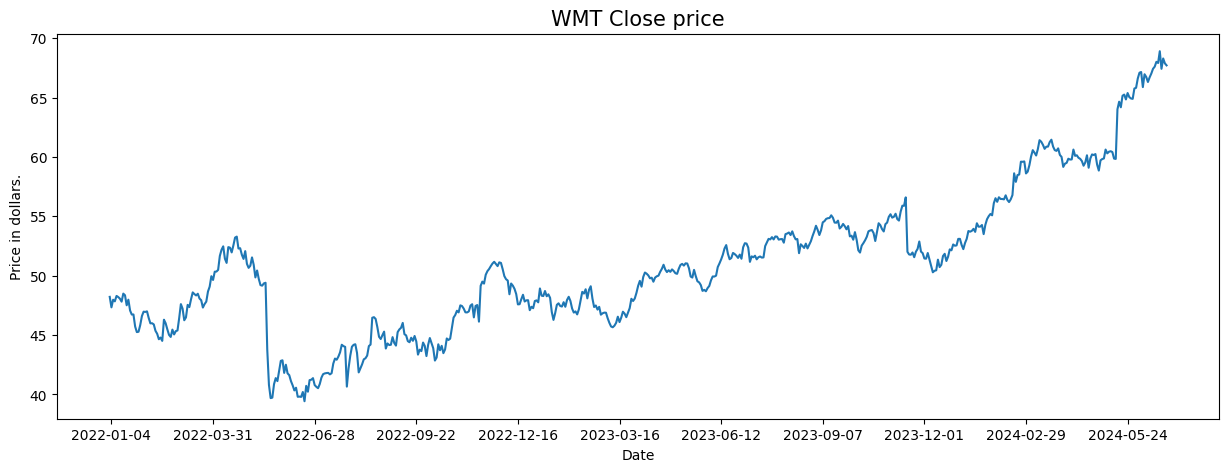

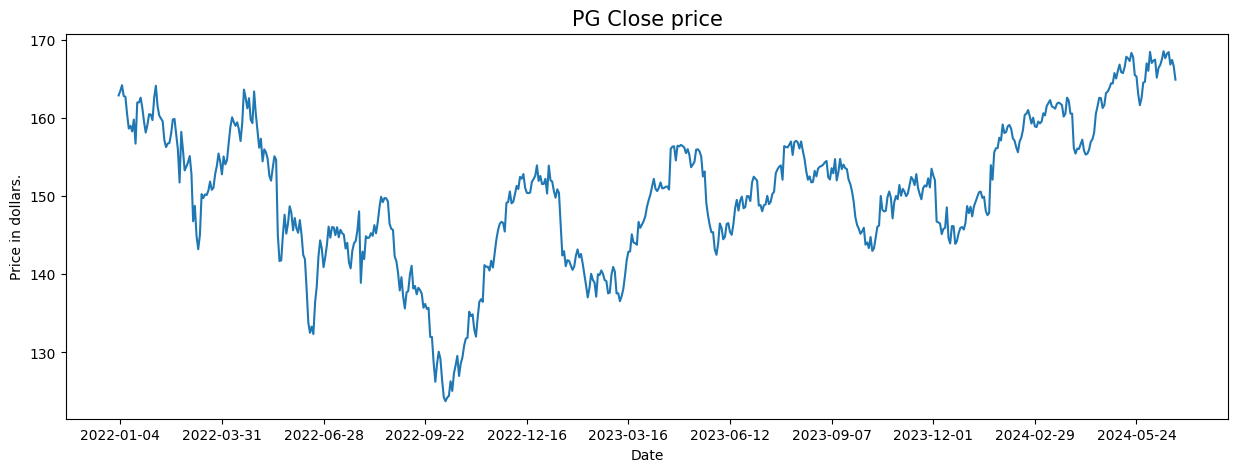

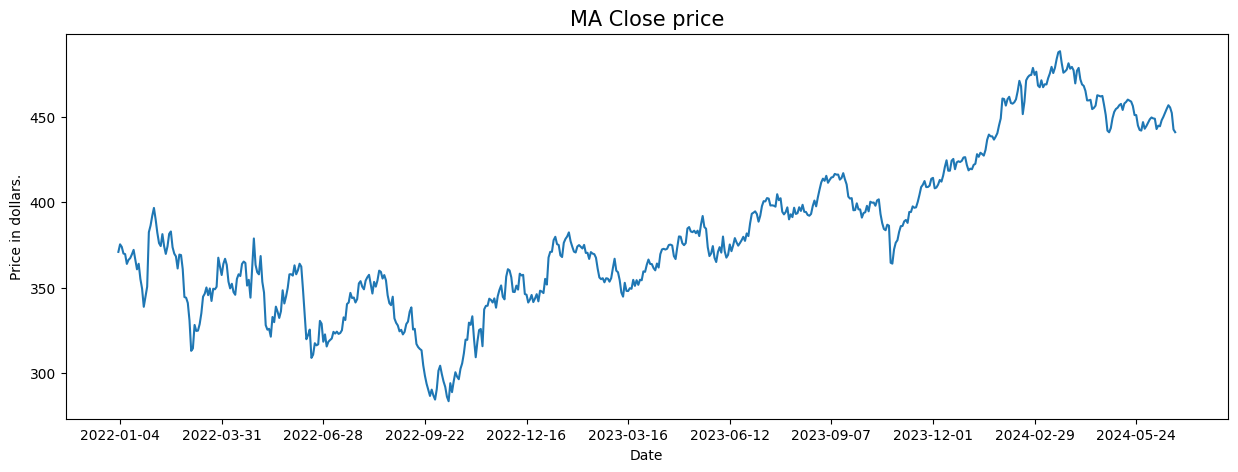

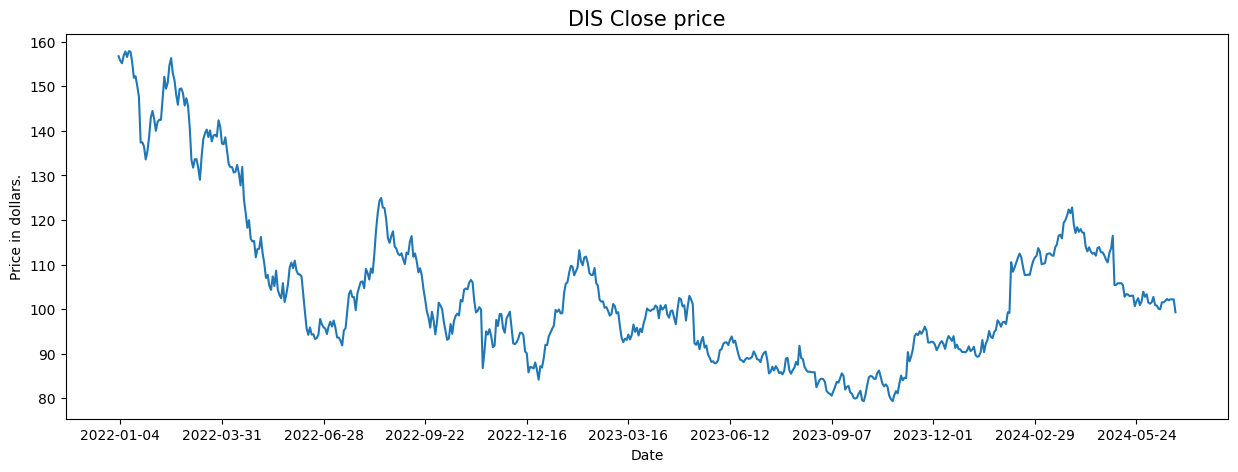

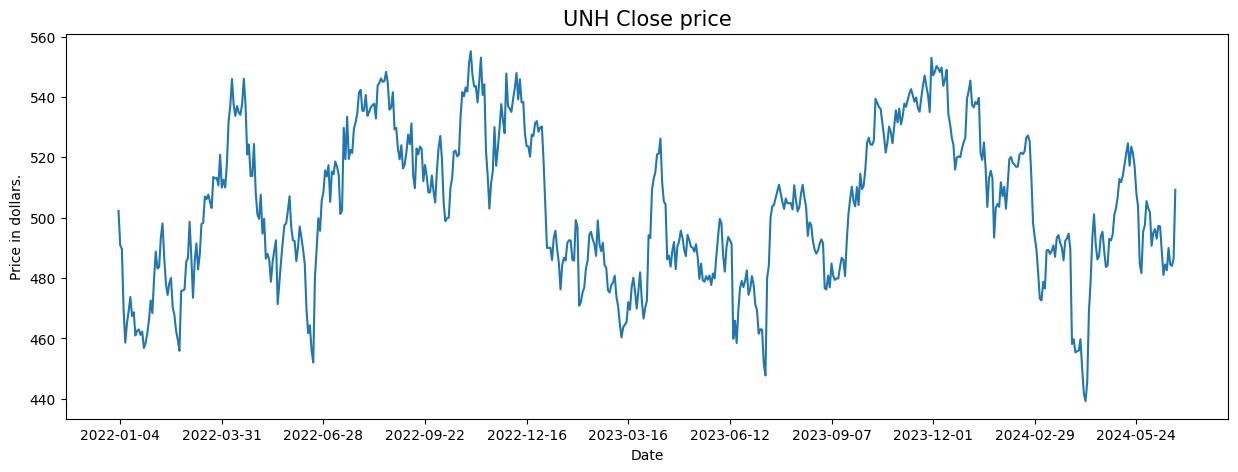

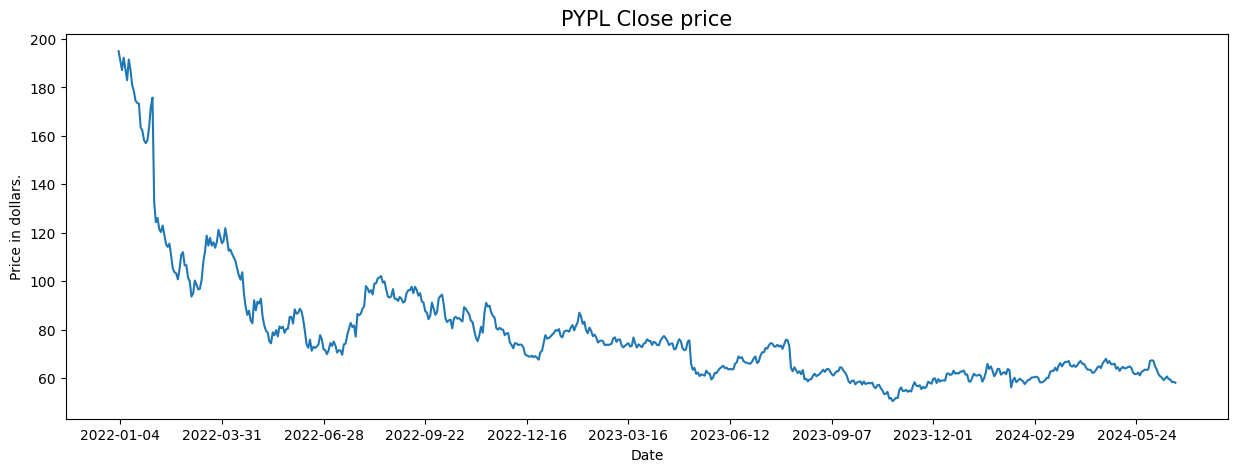

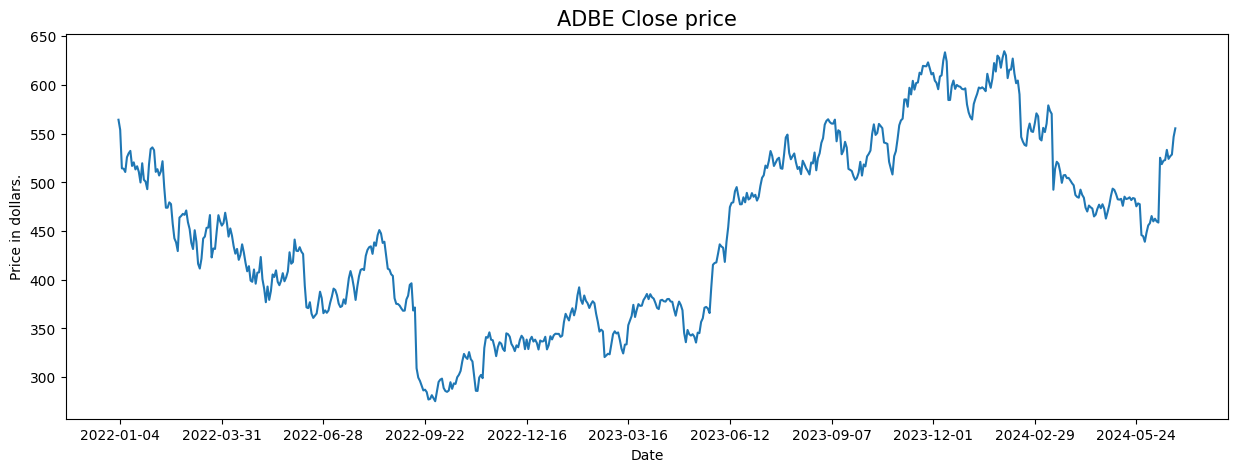

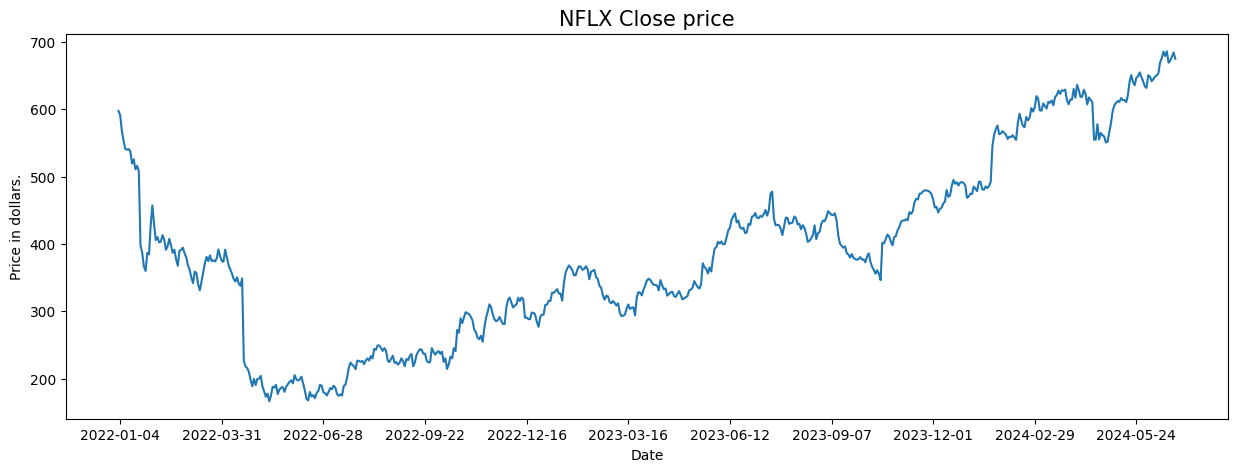

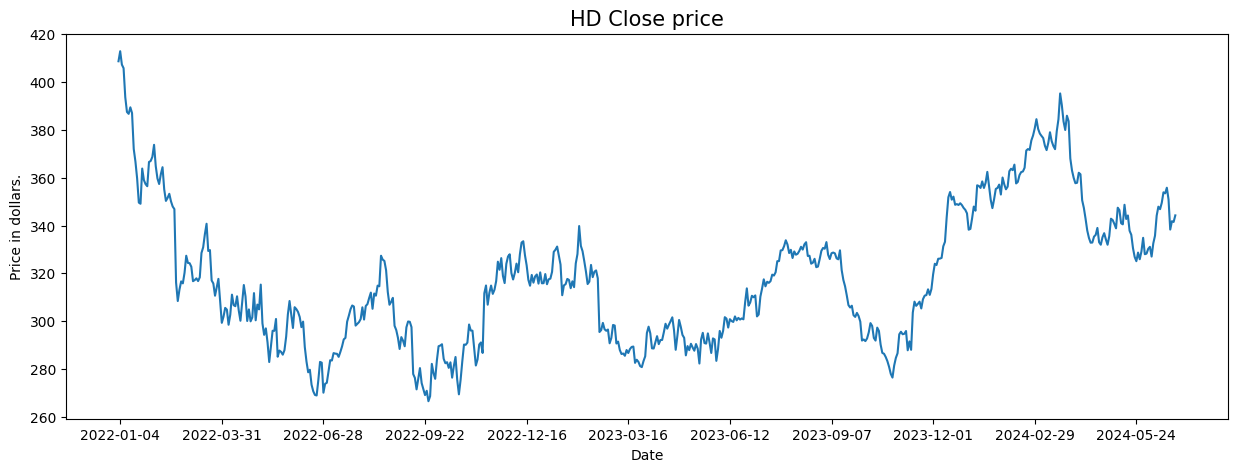

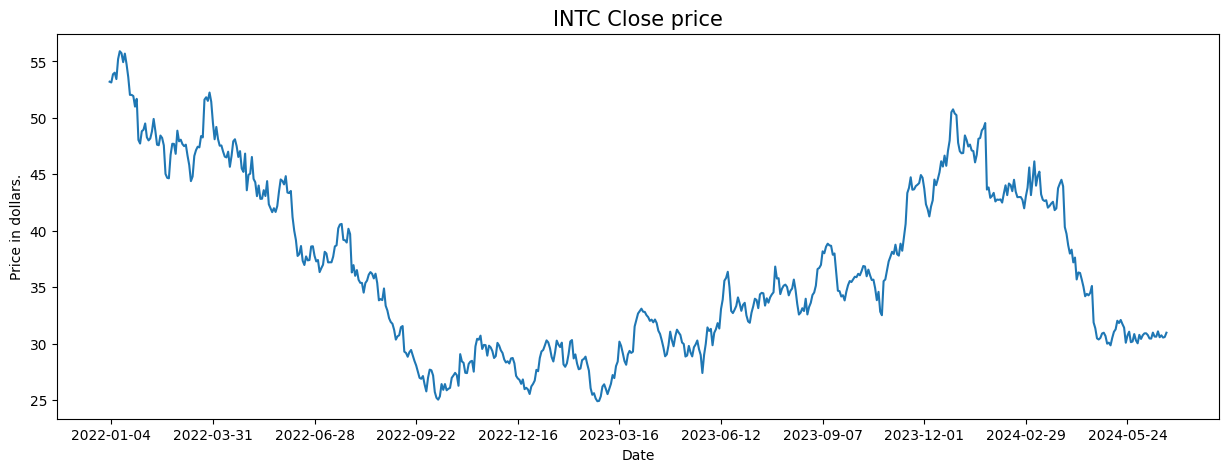

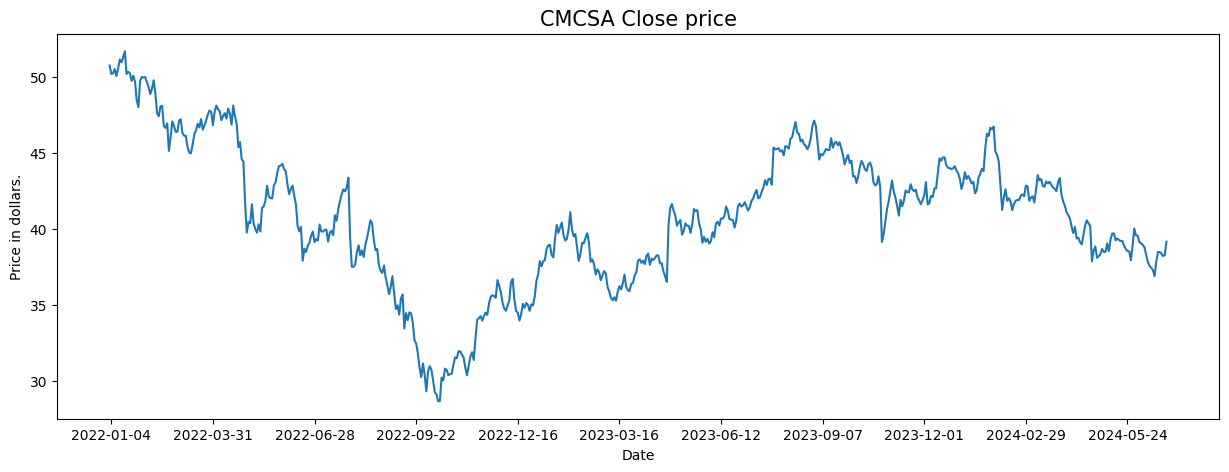

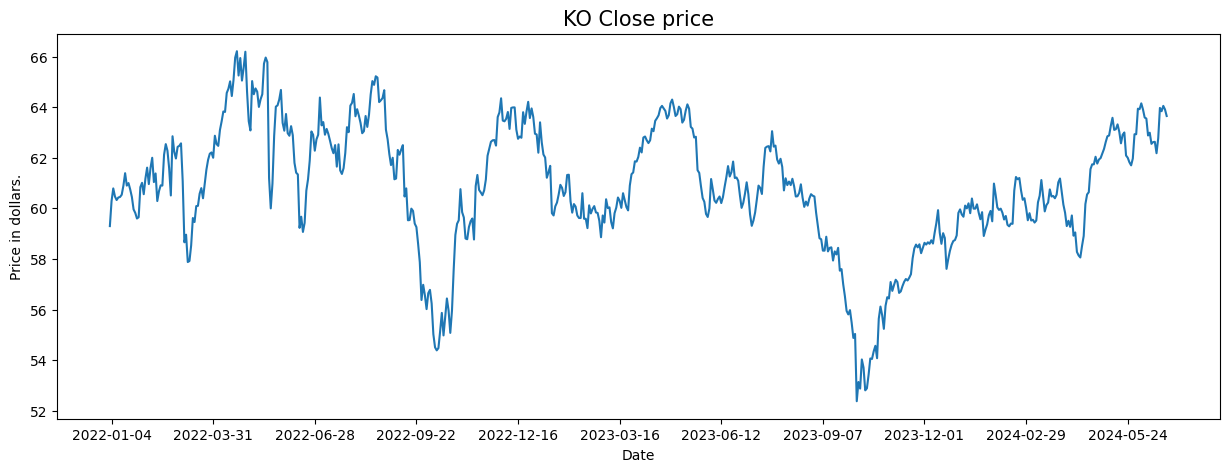

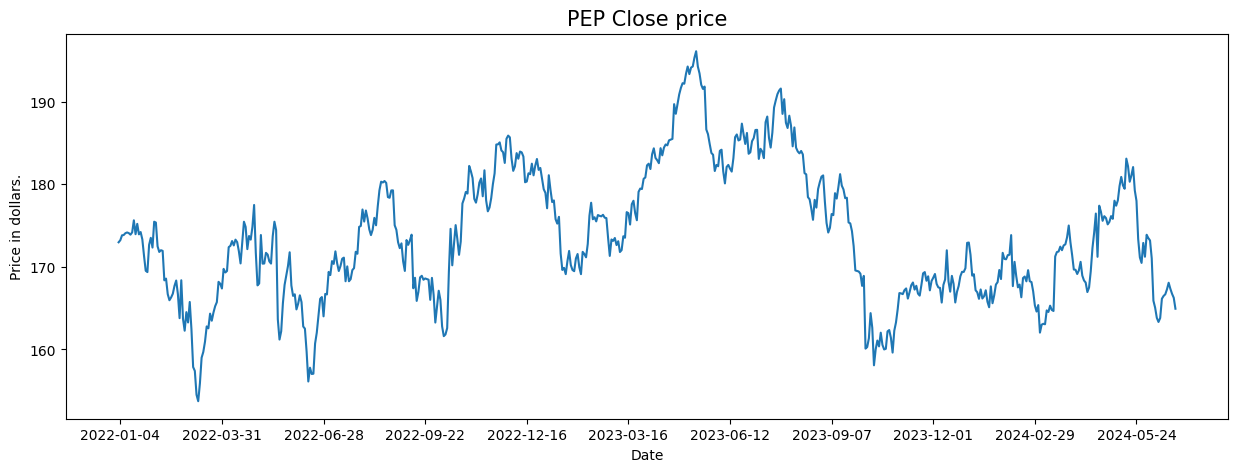

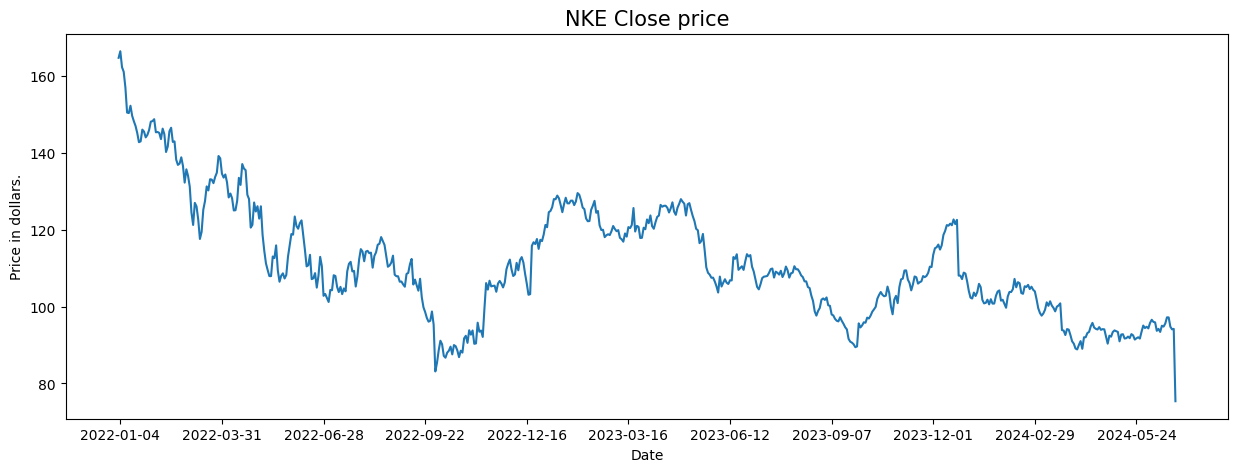

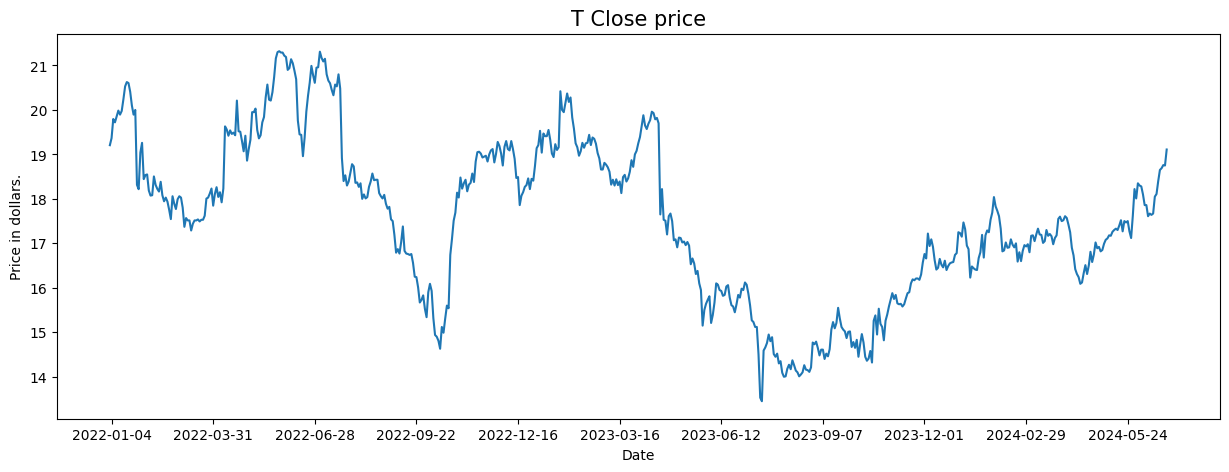

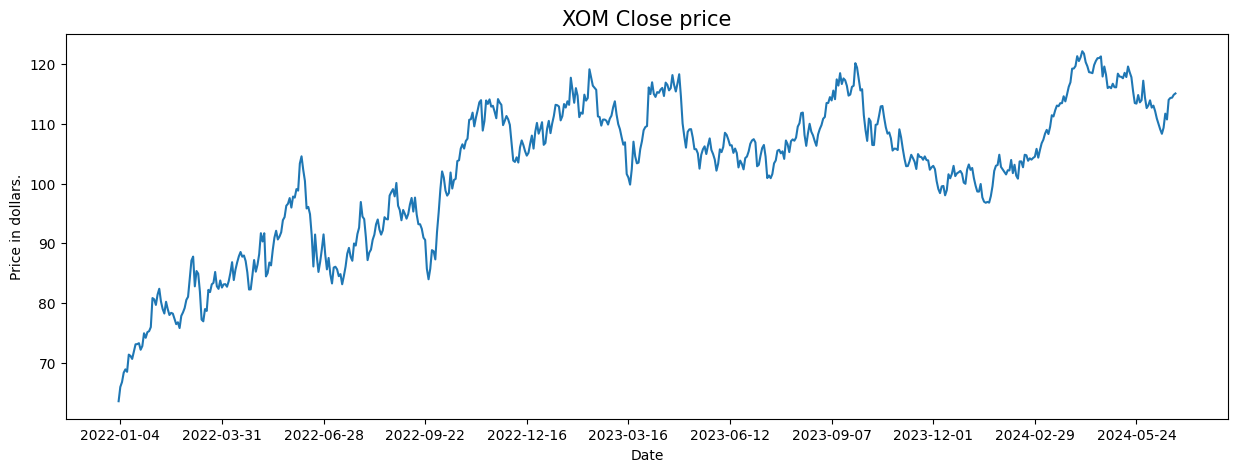

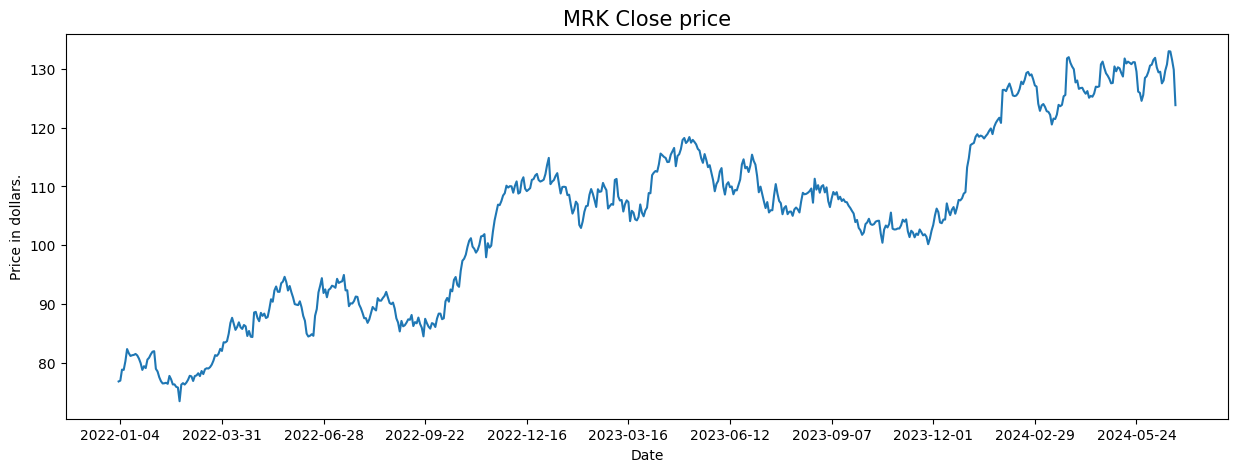

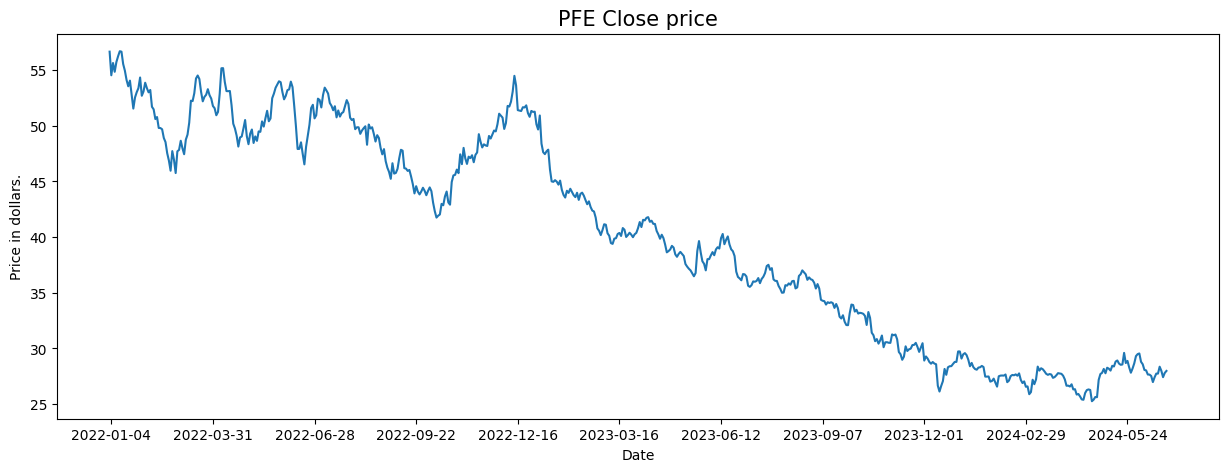

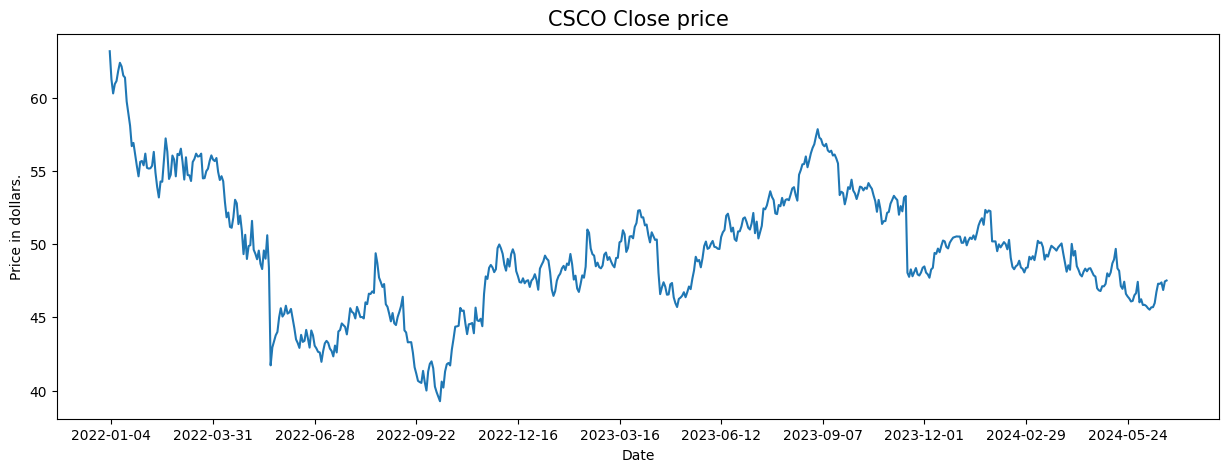

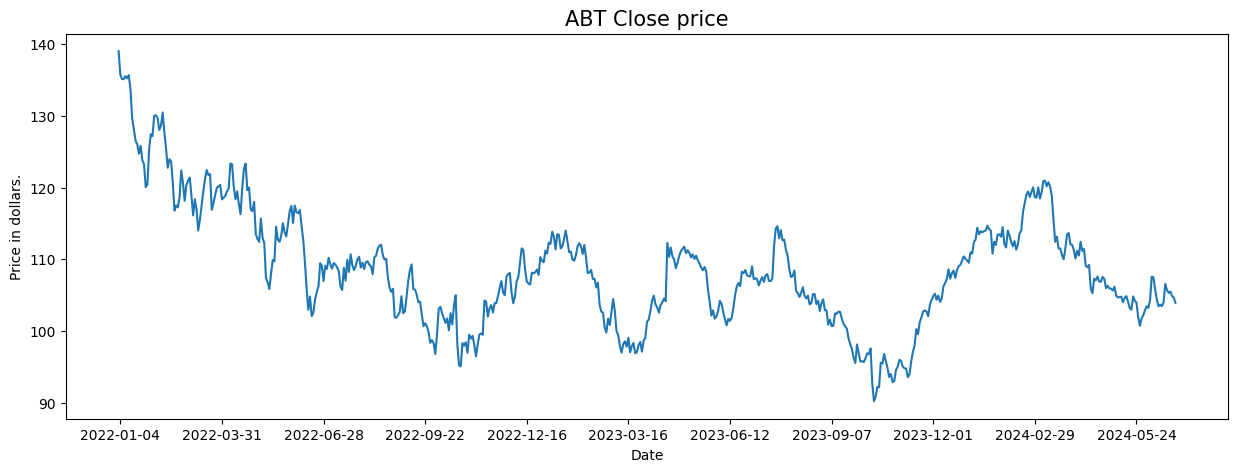

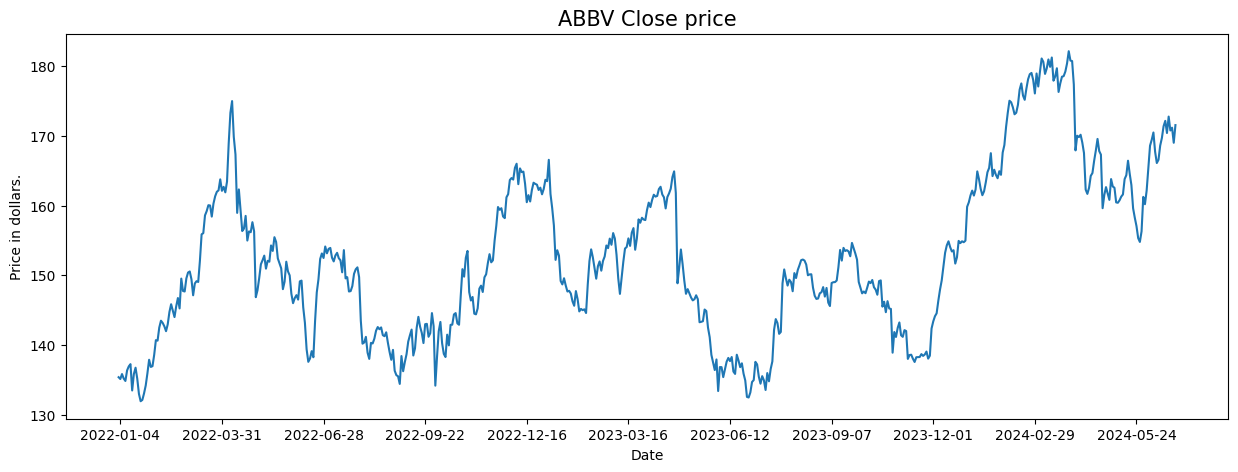

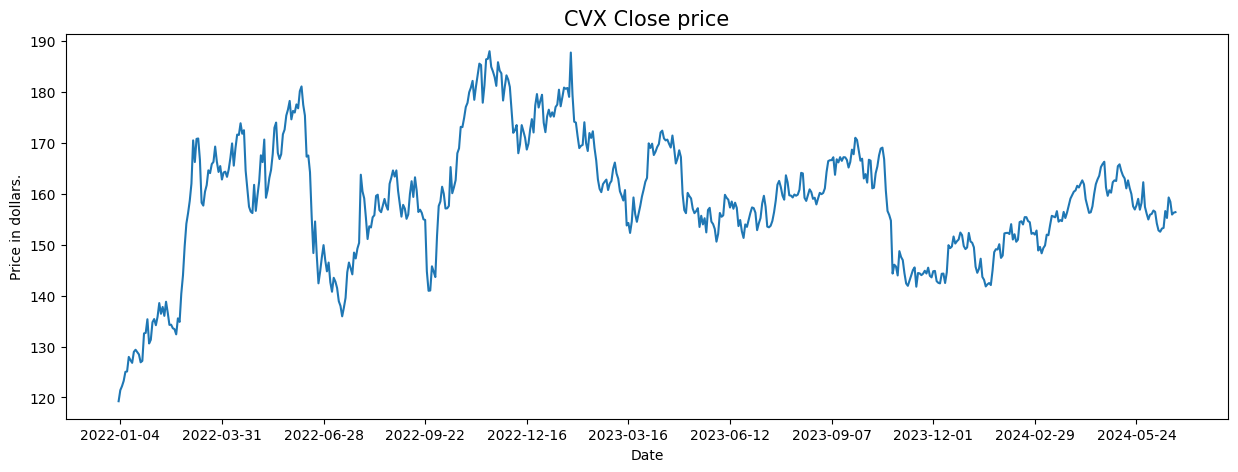

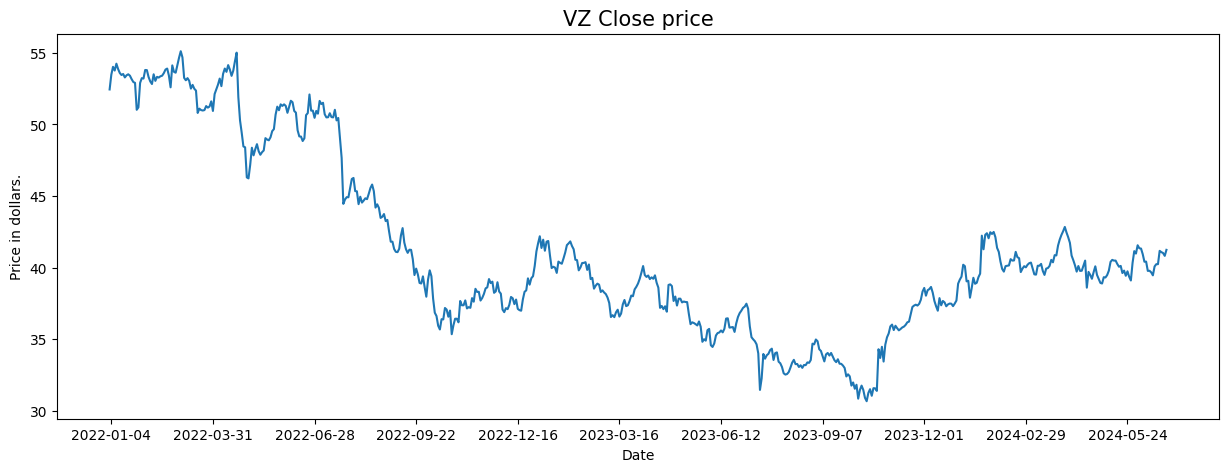

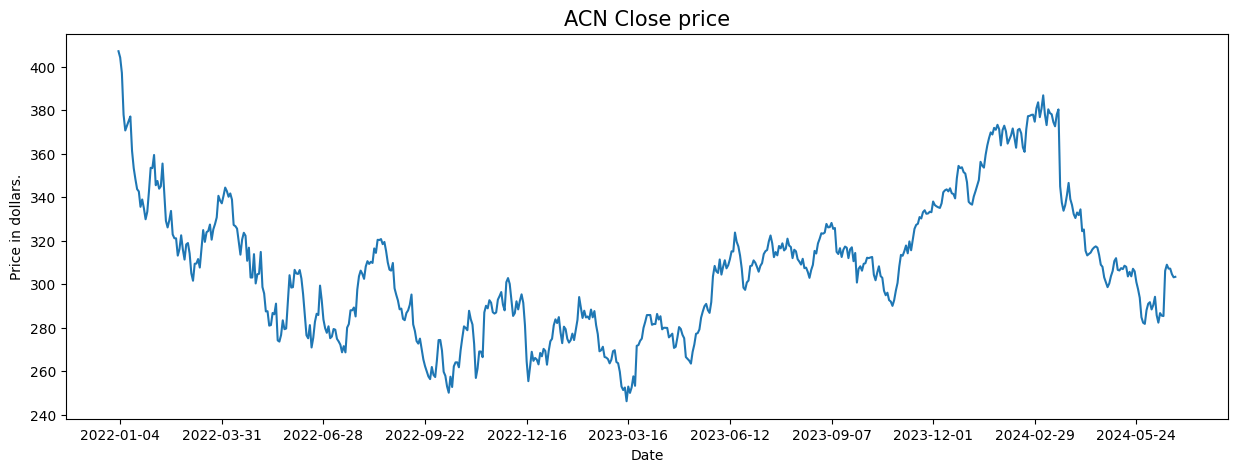

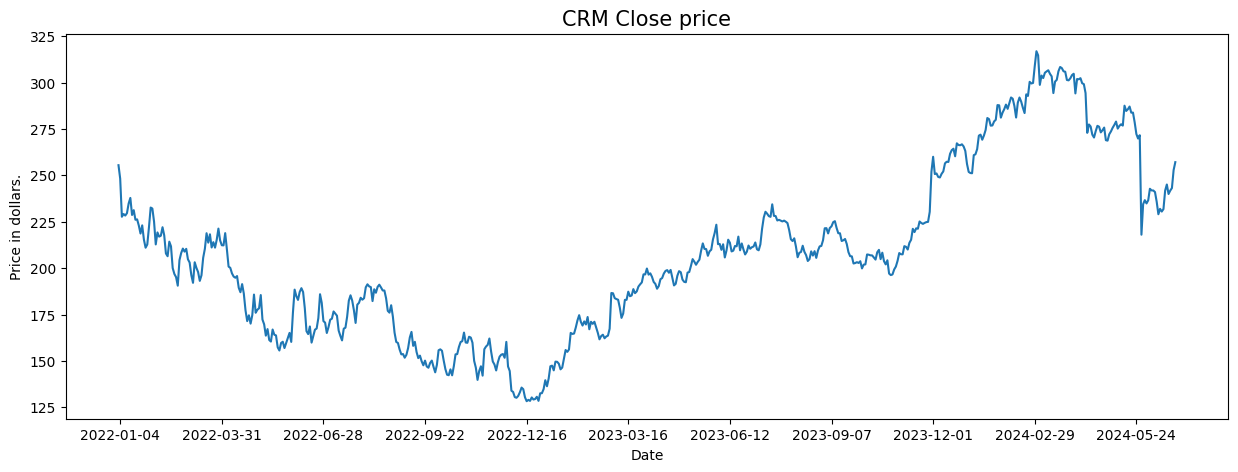

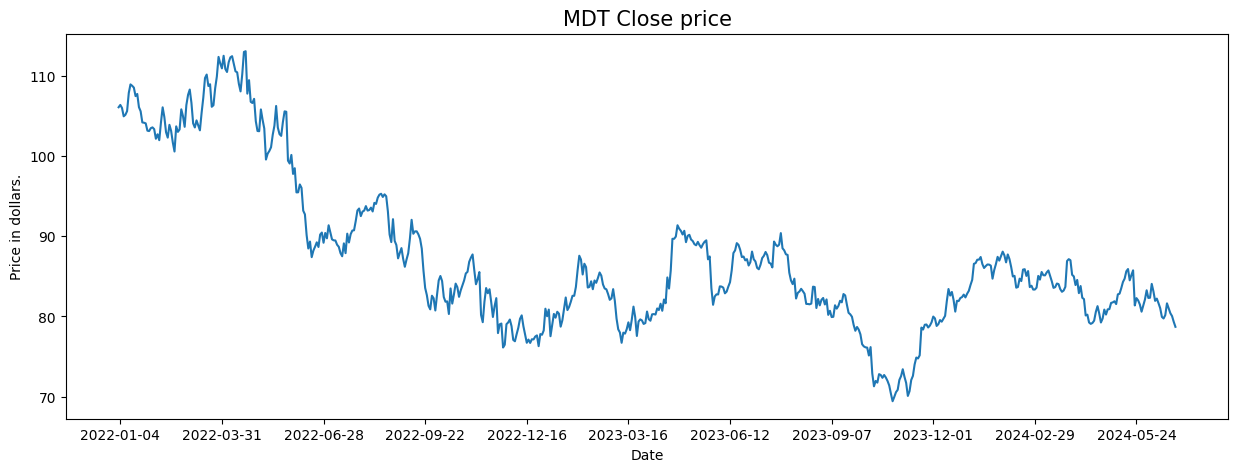

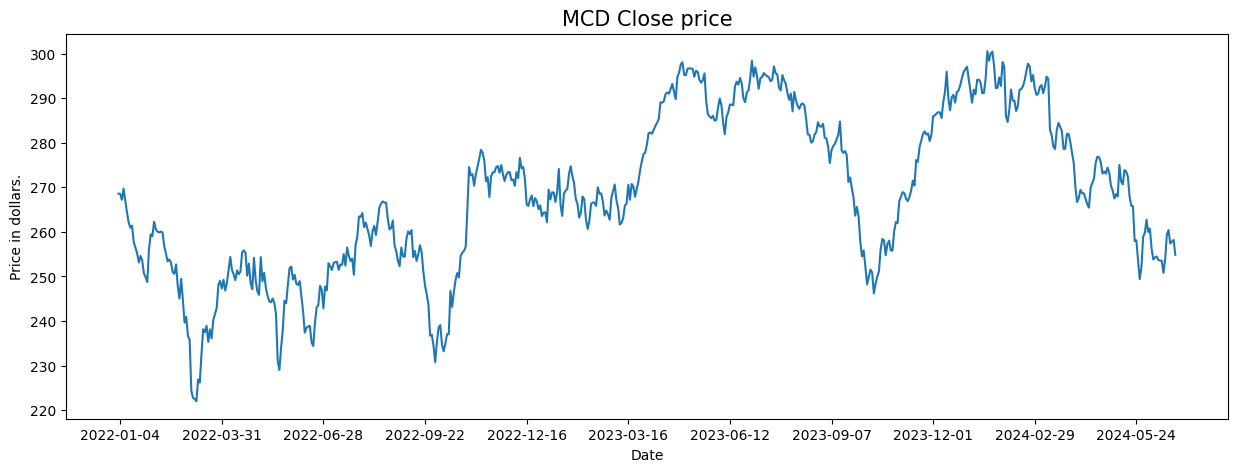

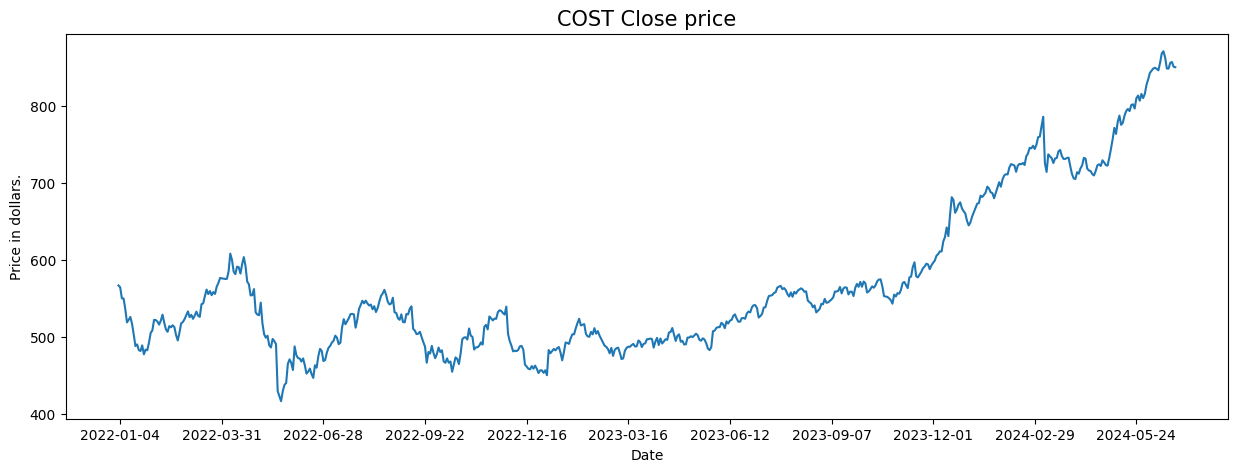

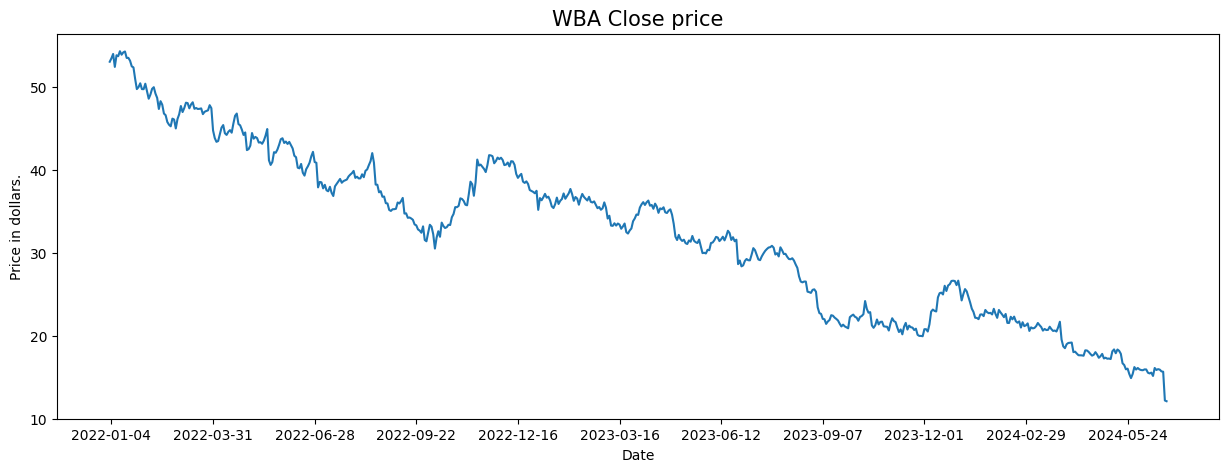

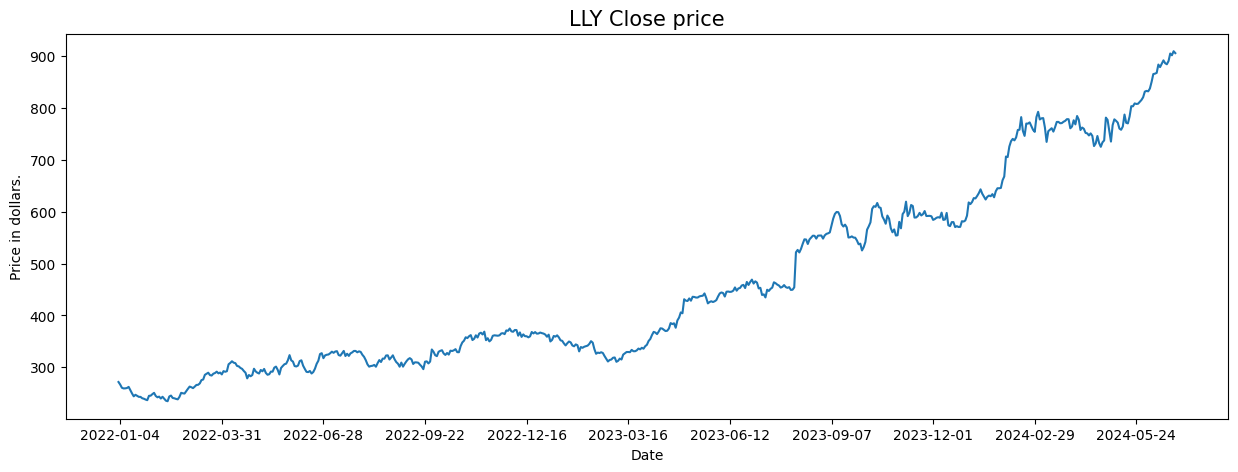

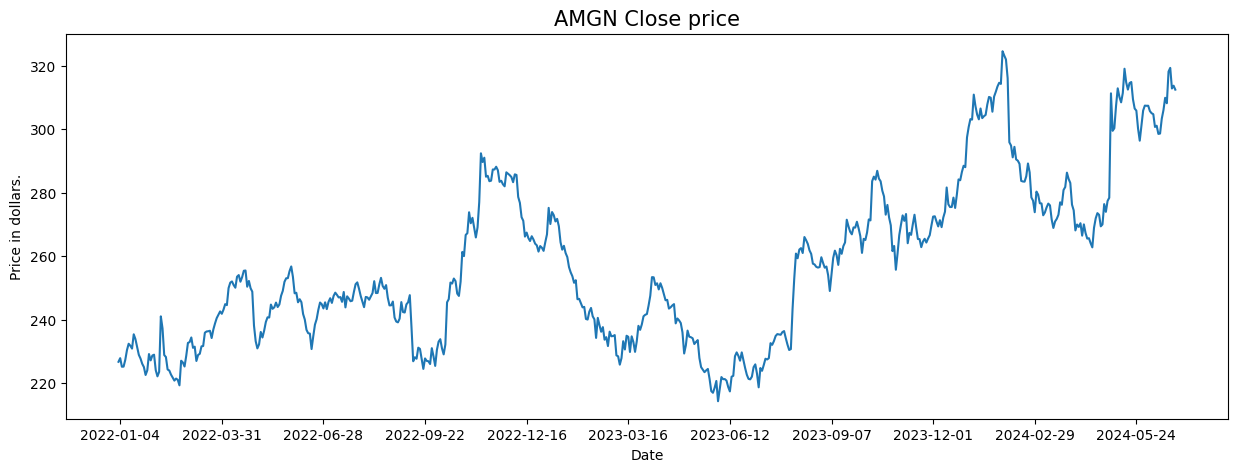

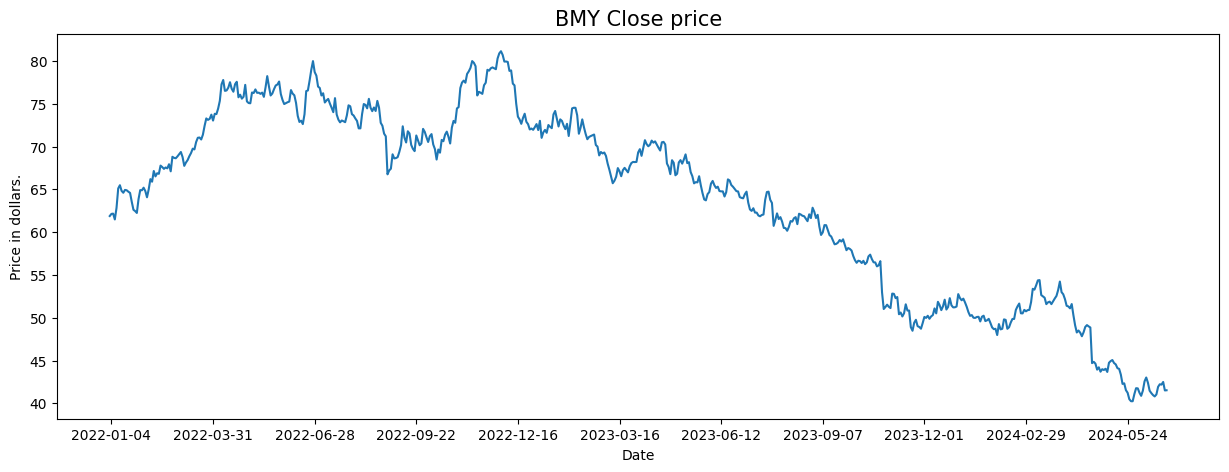

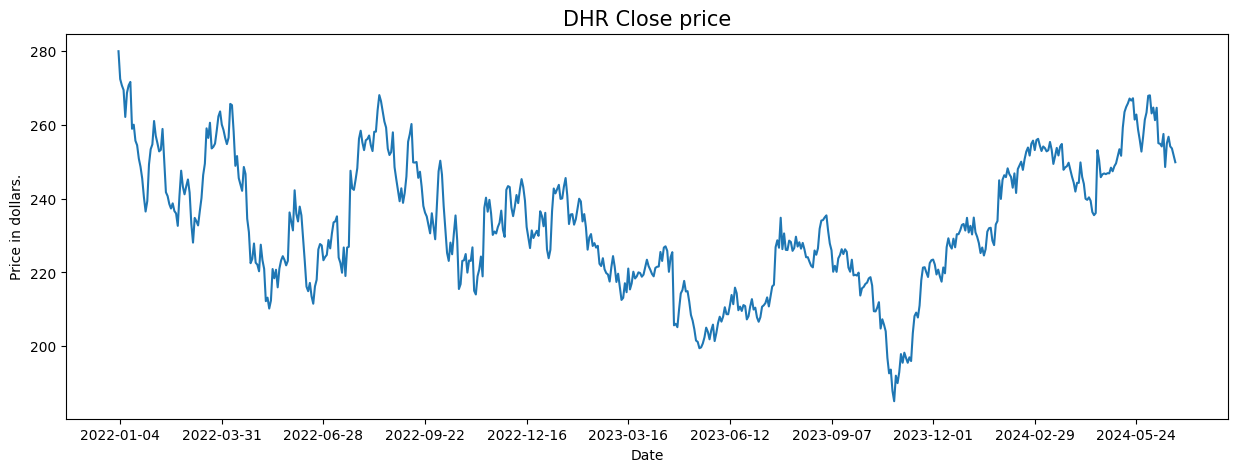

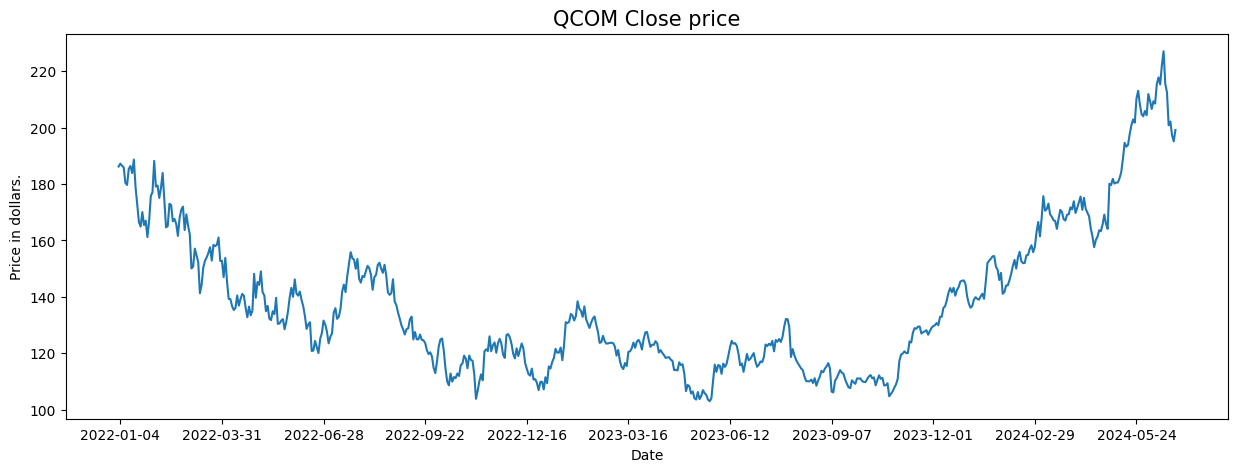

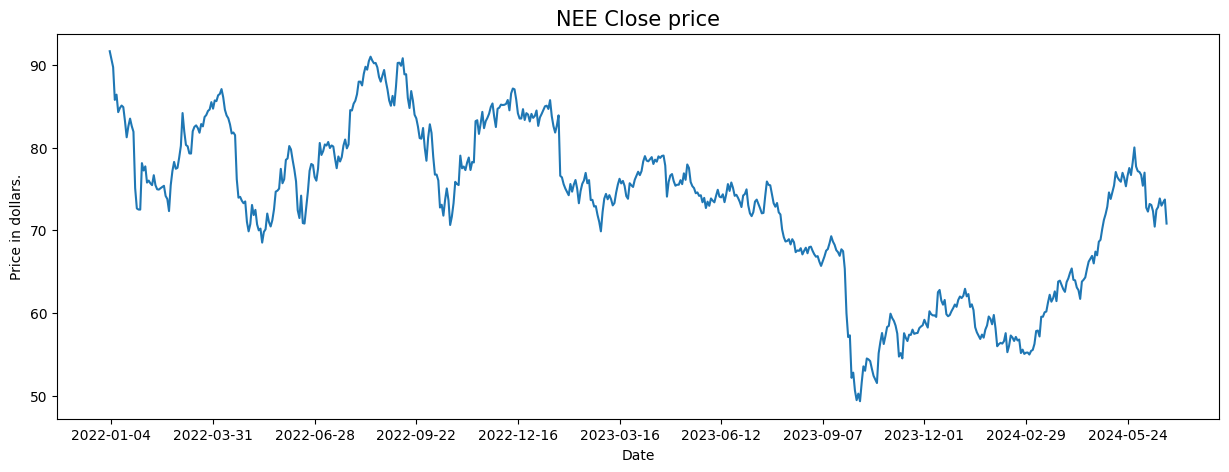

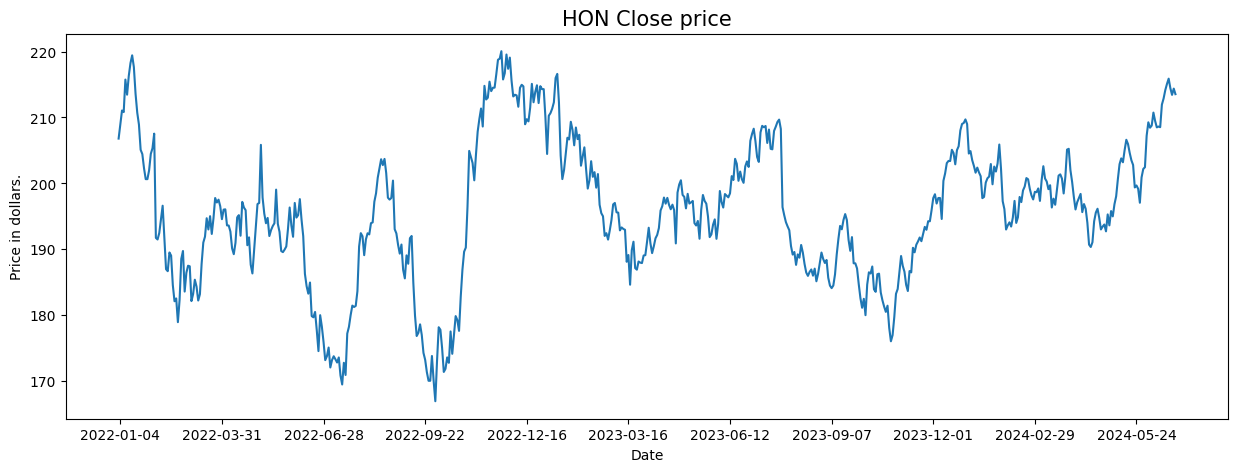

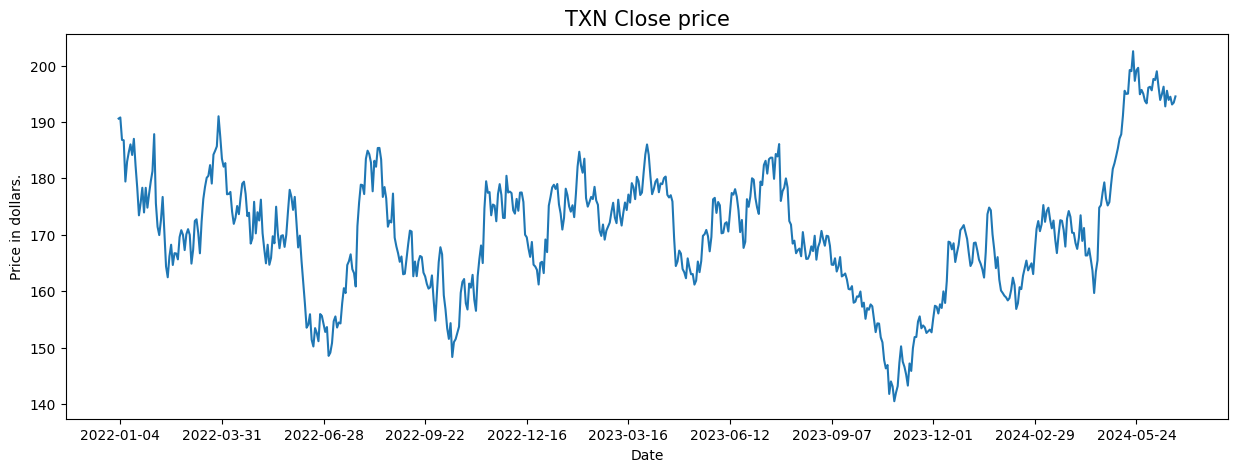

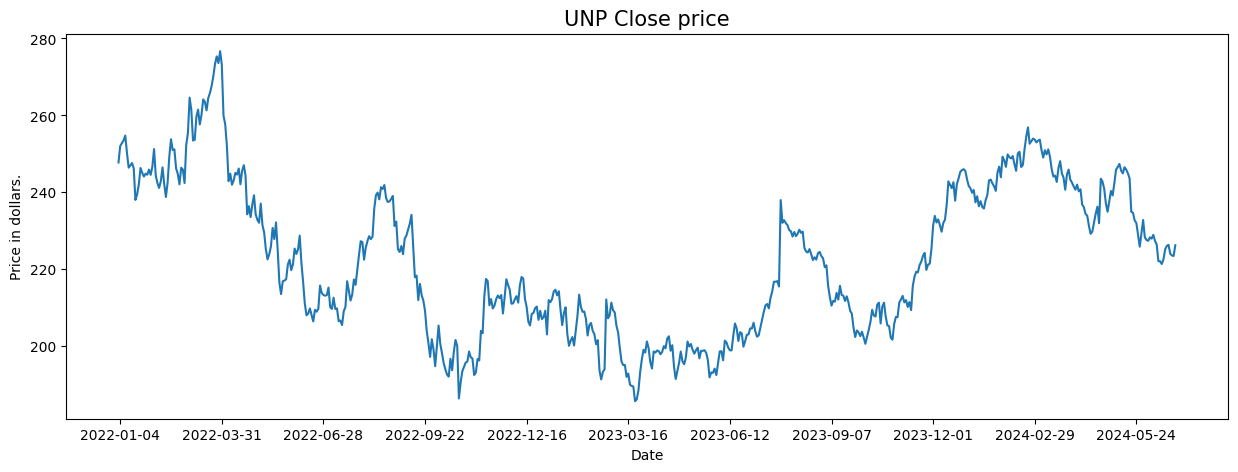

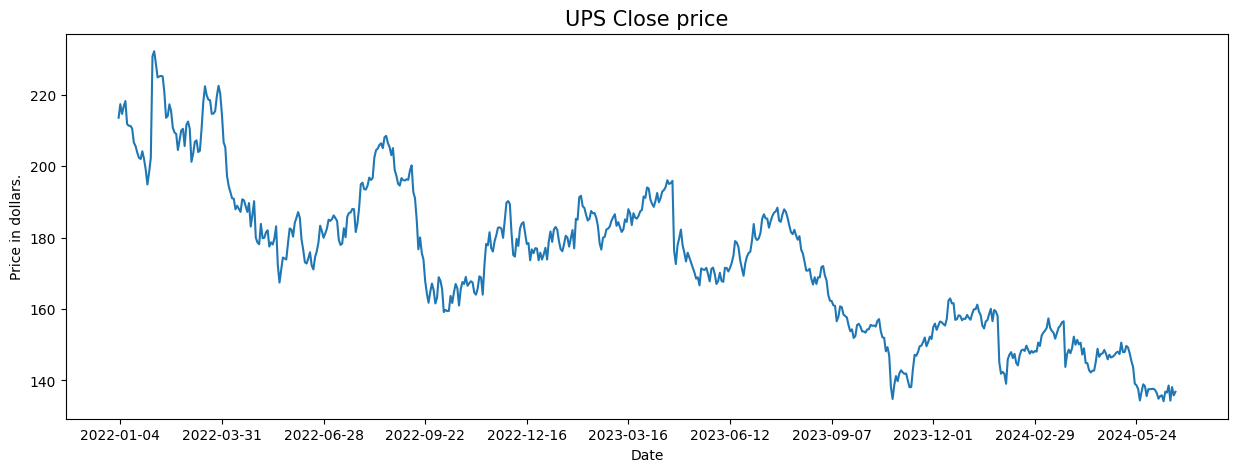

In [15]:
# Makes graphs of the closing prices over time for each company(Used link below to display dates without overcrowding) https://stackoverflow.com/questions/9627686/plotting-dates-on-the-x-axis?__cf_chl_rt_tk=Dnkg8A807Fvd8xC..YUYYUwe6KX98kNpusxjBSoJPLY-1752352883-1.0.1.1-AkSD6orwPfcM2oG3fgwQeGDTNK_I3FZ0UuNo9lWWkuE
for tickers in df['Ticker'].unique():
  comp_df = df[df['Ticker'] == tickers]
  plt.figure(figsize=(15,5))
  sb.lineplot(x='Date', y='Close', data=comp_df)

  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

  plt.title(tickers + ' Close price', fontsize=15)
  plt.ylabel('Price in dollars.')
  plt.show()

In [16]:
# Calculate stock metrics like annualized return, annualized volatility, and Sharpe ratio. Used following links to properly convert daily return into annual return and annual volatility: https://stackoverflow.com/questions/40226883/i-dont-understand-the-usage-of-lambda-and-transform-and-from-this-code-pan http://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#transformation
# Daily return
df['daily_return'] = df.groupby('Ticker')['Close'].pct_change()

# Annualized return and volatility per Ticker — using transform to match DataFrame length
df['ann_return'] = df.groupby('Ticker')['daily_return'].transform(lambda x: x.mean() * 252)
df['ann_volatility'] = df.groupby('Ticker')['daily_return'].transform(lambda x: x.std() * (252 ** 0.5))

# Sharpe ratio, safe division
df['Sharpe_ratio'] = df['ann_return'] / df['ann_volatility']

df.head()

Ticker        Date        Open       Close        High         Low  \
0   AAPL  2022-01-03  177.830002  182.009995  182.880005  177.710007   
1   AAPL  2022-01-04  182.630005  179.699997  182.940002  179.119995   
2   AAPL  2022-01-05  179.610001  174.919998  180.169998  174.639999   
3   AAPL  2022-01-06  172.699997  172.000000  175.300003  171.639999   
4   AAPL  2022-01-07  172.889999  172.169998  174.139999  171.029999   

   Adjusted Close     Volume  daily_return  ann_return  ann_volatility  \
0      179.481110  104487900           NaN    0.098652        0.282404   
1      177.203217   99310400     -0.012692    0.098652        0.282404   
2      172.489609   94537600     -0.026600    0.098652        0.282404   
3      169.610214   96904000     -0.016693    0.098652        0.282404   
4      169.777847   86709100      0.000988    0.098652        0.282404   

   Sharpe_ratio  
0       0.34933  
1       0.34933  
2       0.34933  
3       0.34933  
4       0.34933

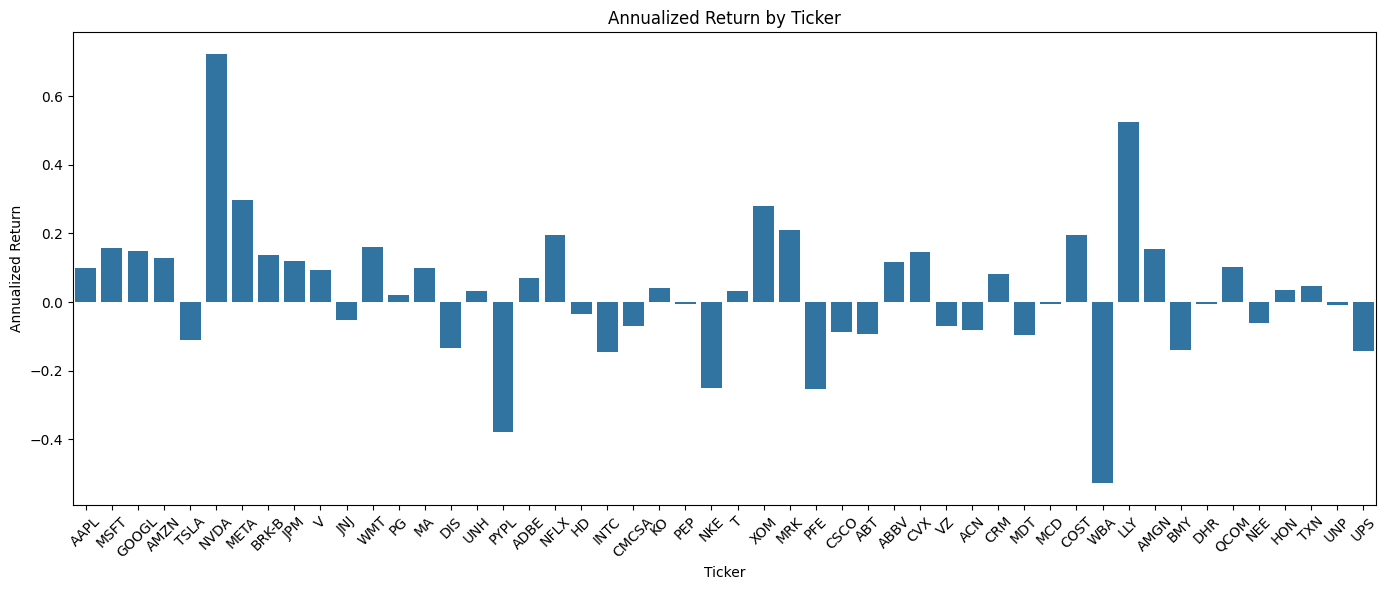

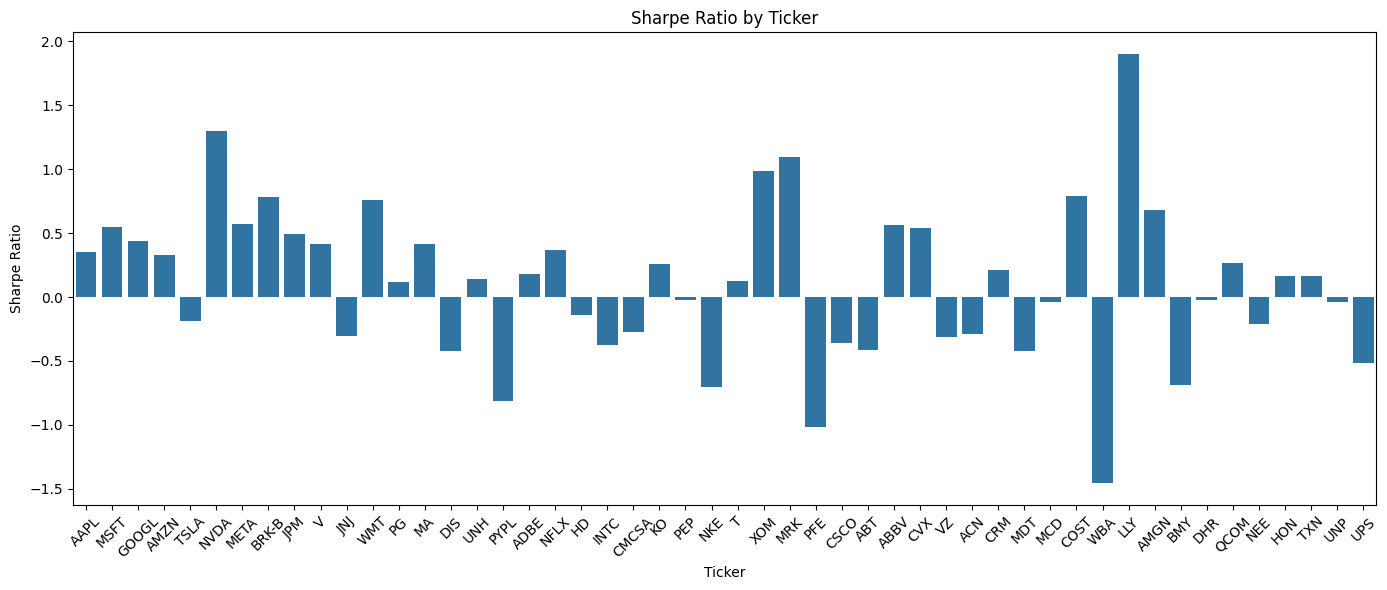

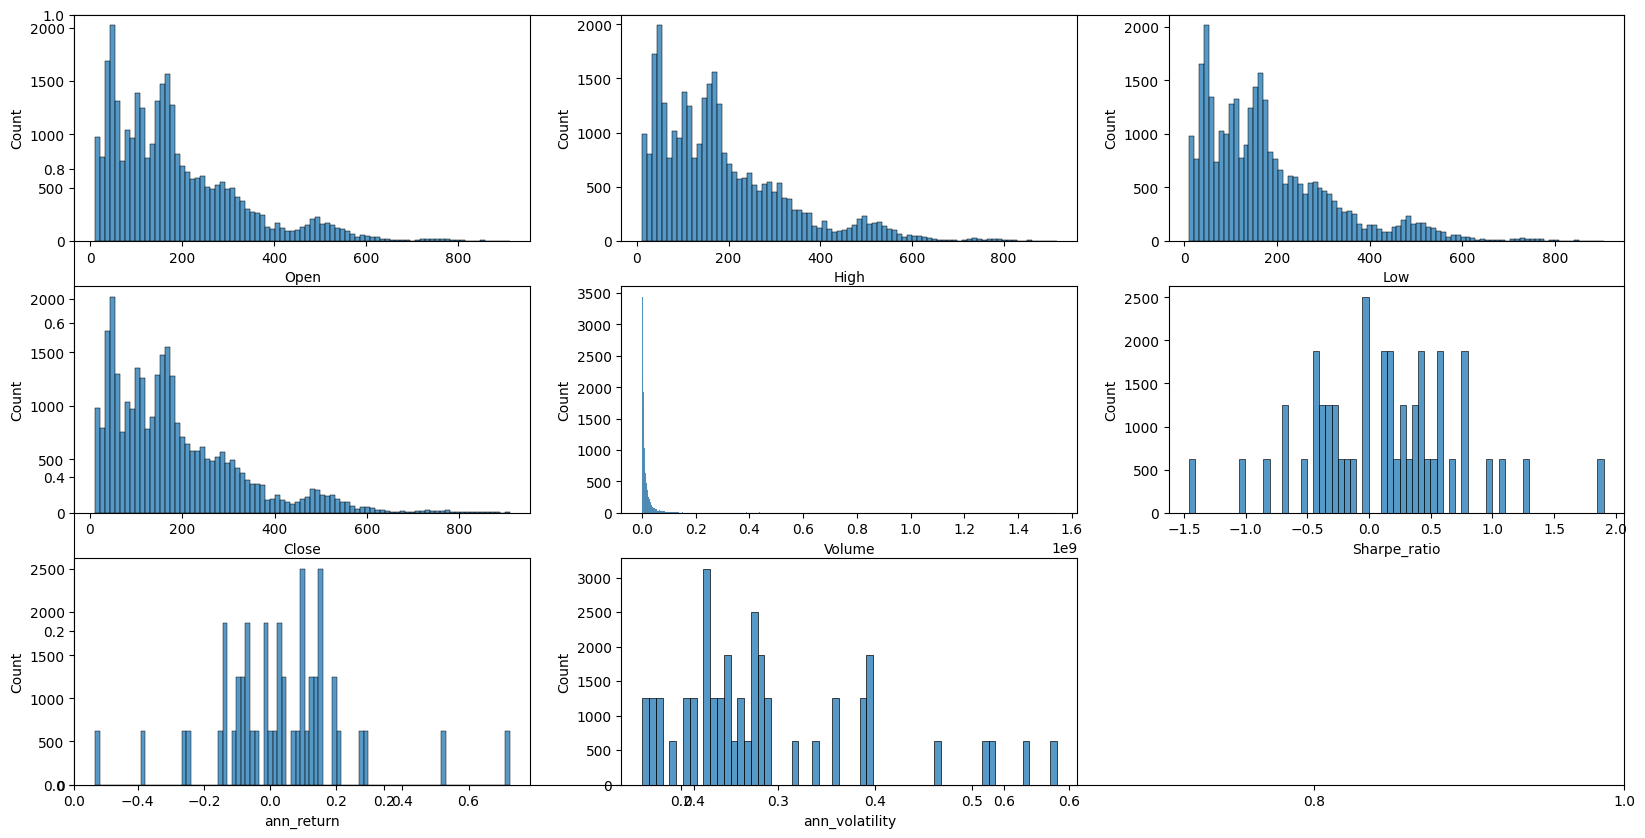

In [17]:
#Make graphs with stock metrics
#Annual Return by Ticker(Bargraph)
plt.figure(figsize=(14, 6))
sb.barplot(data=df, x='Ticker', y='ann_return')
plt.title('Annualized Return by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Annualized Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

#Sharpe Ratio by Ticker(Bargraph)
plt.figure(figsize=(14, 6))
sb.barplot(data=df, x='Ticker', y='Sharpe_ratio')
plt.title('Sharpe Ratio by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sharpe_ratio', 'ann_return', 'ann_volatility']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(3,3,i+1)
  sb.histplot(df[col])
plt.show()

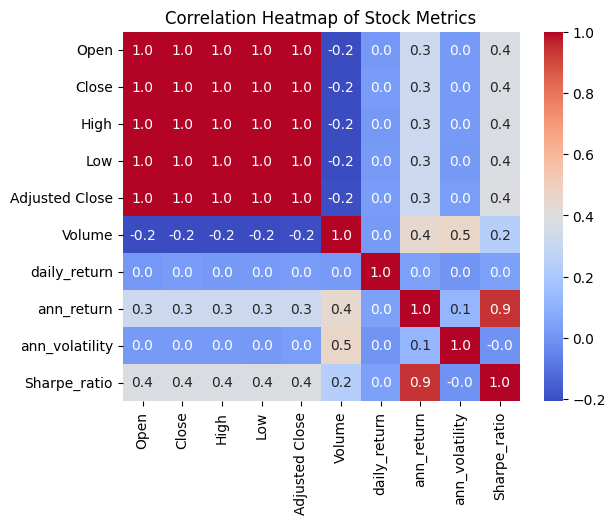

In [18]:
# Creating a correlation heatmap
#Filtering out categorical colomns and computing corr matrix
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

#Plot the heatmap
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Heatmap of Stock Metrics")
plt.show()

In [19]:
# Calculating Q1 (25th percentile) and Q3 (75th percentile) for numerical columns
q_1 = df[['Open','Close','High','Low','Adjusted Close','Volume']].quantile(0.25)
q_3 = df[['Open','Close','High','Low','Adjusted Close','Volume']].quantile(0.75)

# IQR for each column
iqr = q_3 - q_1

# Lower and upper bounds for outliers
l_bound = q_1 - 1.5 * iqr
u_bound = q_3 + 1.5 * iqr

# Capping outliers by replacing them with the nearest value within the lower and upper bounds
data_capped = df.copy()
data_capped[['Open', 'Close', 'High', 'Low', 'Adjusted Close', 'Volume']] = data_capped[['Open', 'Close', 'High', 'Low', 'Adjusted Close', 'Volume']].clip(lower=l_bound, upper=u_bound, axis=1)

In [20]:
# Function to get mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Dictionary to store filtered DataFrames
comp_data = {}

# List of company names
comp_names = df['Ticker'].unique()

# Filtering data for each company and store in the dictionary
for comp in comp_names:
    comp_data[comp] = df[df['Ticker'] == comp]

# Function to analyze multiple stocks and get feedback
def analyze_multiple_stocks(companies,start_date,end_date):
    feedback = {}
    for company in companies:
        stock_data = comp_data[comp]
        stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]

        # Ensure 'Date' is in datetime format and set it as index
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        stock_data.set_index('Date', inplace=True)

        # Closing prices
        clos_prices = stock_data['Close']

        # ARIMA model for company's stock
        model = ARIMA(clos_prices, order=(5,1,0))
        modelFit = model.fit()

        # Making predictions for company's stock
        pred = modelFit.predict(start=0, end=len(clos_prices)-1, typ='levels')
        pred.index = clos_prices.index  # Align predictions with the original dates

        # Plotting the original and predicted closing prices
        plt.figure(figsize=(20,8))
        plt.plot(clos_prices, color='pink',label='Original')
        plt.plot(pred, color='purple',label='Predicted')
        plt.title(f'Stock Price of {company}: Original VS Predicted')
        plt.xlabel('Time')
        plt.ylabel('Price in $')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Checking error percentage
        mape_comp = mean_absolute_percentage_error(clos_prices, pred)
        print(f"MAPE for {company}: {mape_comp:.2f}%")

        # Forecasting future values
        forecast_steps = 10
        forecast = modelFit.get_forecast(steps=forecast_steps)
        forecast_index = pd.date_range(start=clos_prices.index[-1], periods=forecast_steps+1, freq='D')[1:]
        forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

        # Plotting forecasted values
        plt.figure(figsize=(20,8))
        plt.plot(clos_prices, color='yellow', label='Original')
        plt.plot(pred, color='red', label='Predicted')
        plt.plot(forecast_series, color='orange', label='Forecast')
        plt.title(f'Stock Price of {company}: Forecast')
        plt.xlabel('Time')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)
        plt.show()

        last_actual = clos_prices[-1]
        last_forecast = forecast_series[-1]
        feedback[company] = (last_actual, last_forecast)

        print(f"{company} forecast:\n", forecast_series)

        return feedback

Welcome to the Stock Advisor!
Available stocks:
AAPL, MSFT, GOOGL, AMZN, TSLA, NVDA, META, BRK-B, JPM, V, JNJ, WMT, PG, MA, DIS, UNH, PYPL, ADBE, NFLX, HD, INTC, CMCSA, KO, PEP, NKE, T, XOM, MRK, PFE, CSCO, ABT, ABBV, CVX, VZ, ACN, CRM, MDT, MCD, COST, WBA, LLY, AMGN, BMY, DHR, QCOM, NEE, HON, TXN, UNP, UPS
Enter stock(s) separated by commas (example: AAPL, TSLA): AAPL
Enter a start date (YYYY-MM-DD): 2023-01-01
Enter an end date (YYYY-MM-DD): 2024-01-01

Analyzing your stocks...



/tmp/ipython-input-20-2571763990.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been

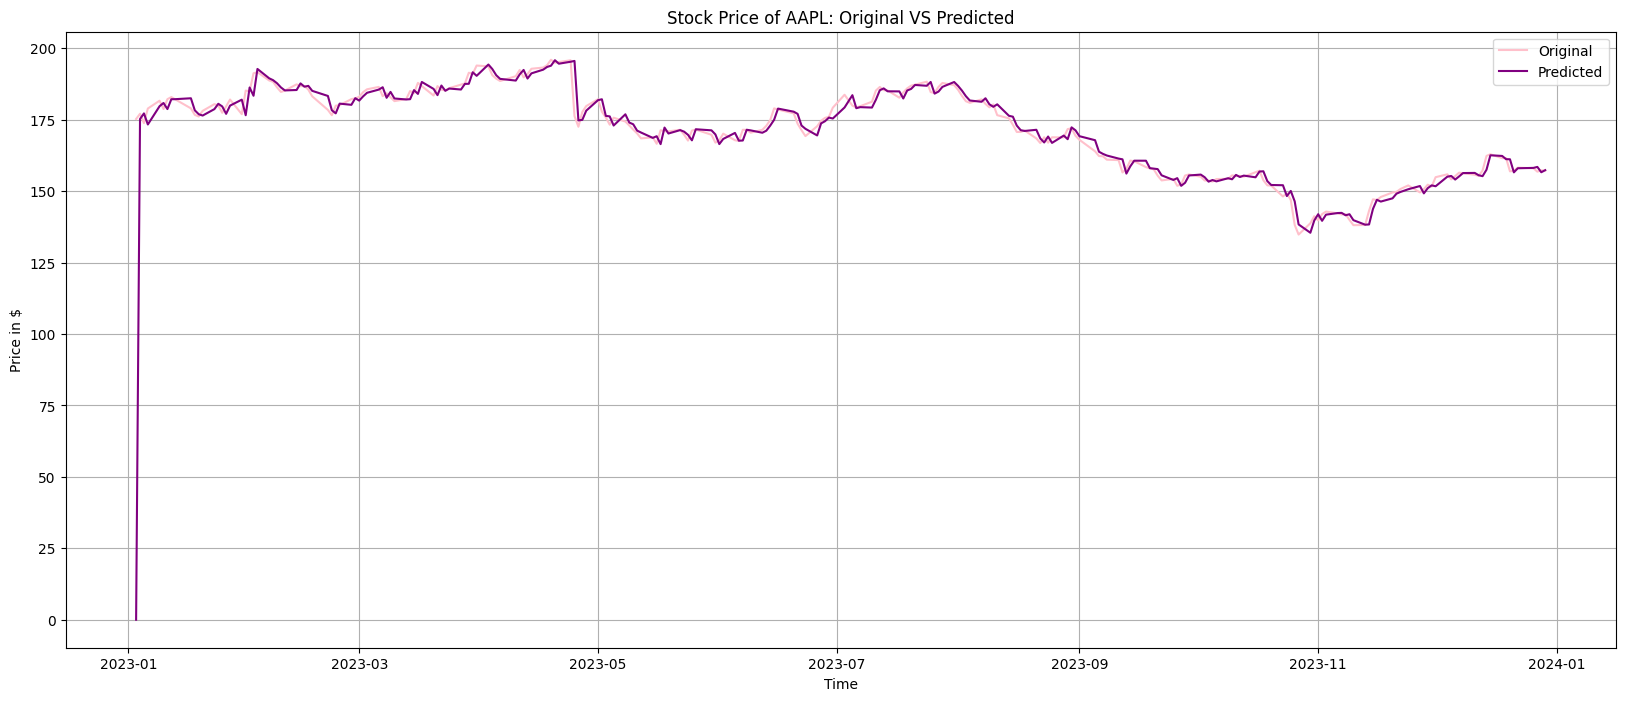

MAPE for AAPL: 1.43%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


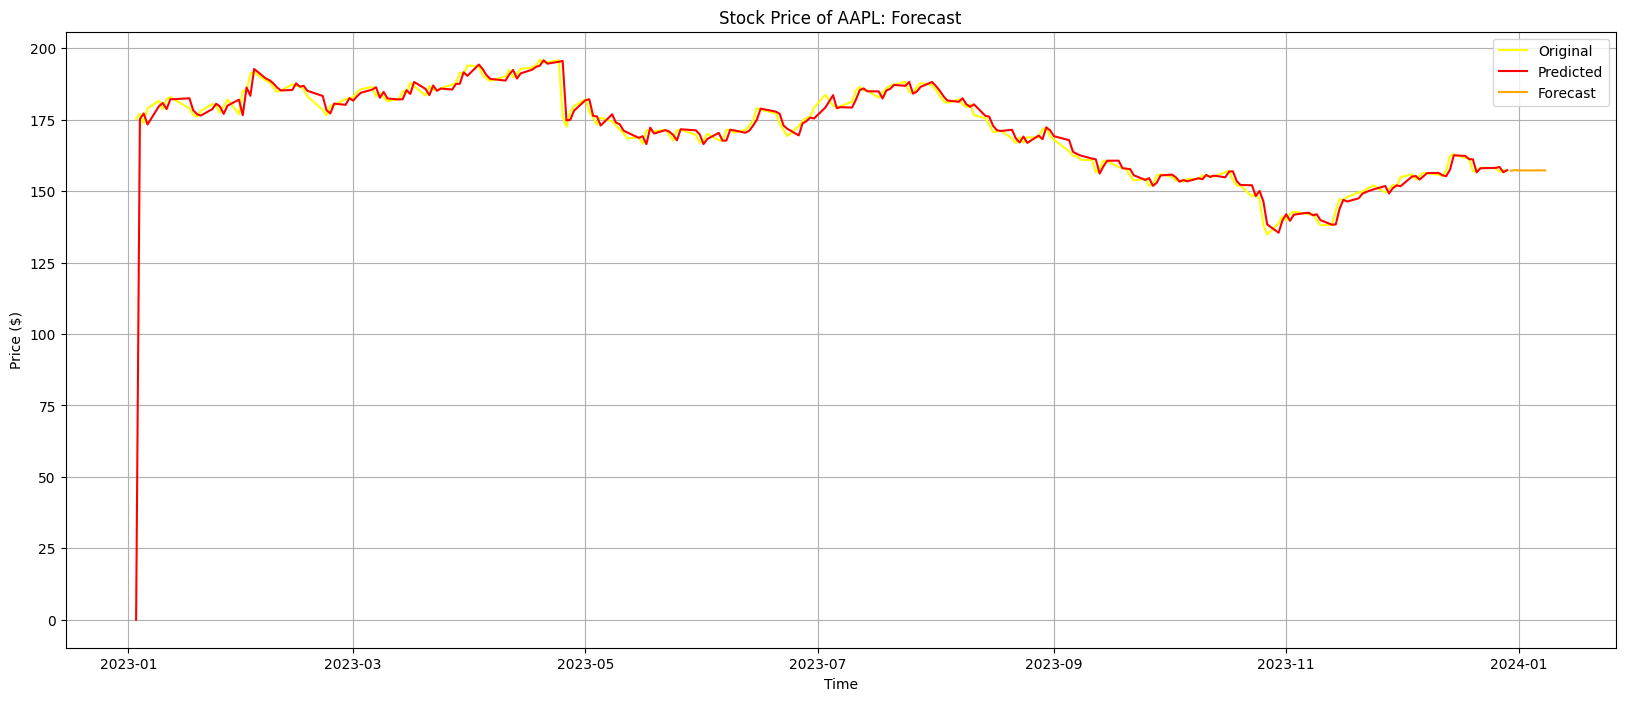

/tmp/ipython-input-20-2571763990.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_actual = clos_prices[-1]
/tmp/ipython-input-20-2571763990.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_forecast = forecast_series[-1]


AAPL forecast:
 2023-12-30    157.191134
2023-12-31    157.366900
2024-01-01    157.287651
2024-01-02    157.279453
2024-01-03    157.296964
2024-01-04    157.272605
2024-01-05    157.283689
2024-01-06    157.287359
2024-01-07    157.282928
2024-01-08    157.286119
Freq: D, dtype: float64
Recommendation for AAPL: You should BUY

Feedback for AAPL:
Was this recommendation helpful? (Yes/No): Yes
Any comments or suggestions? (Press Enter to skip): 

Summary:
Stocks analyzed --> AAPL
Date range: 2023-01-01 to 2024-01-01
Thank you for using the Stock Advisor!
Do you want to run this again? (yes/no): no


In [21]:
run = True

while run == True:
  # Interactive system for user
  print("Welcome to the Stock Advisor!")
  print("Available stocks:")
  print(", ".join(comp_names))

  # Input tickers
  selected_tickers = input("Enter stock(s) separated by commas (example: AAPL, TSLA): ")
  selected_tickers = [ticker.strip().upper() for ticker in selected_tickers.split(",")]

  # Check if tickers valid
  valid_tickers = set(comp_names)
  selected_tickers = [ticker for ticker in selected_tickers if ticker in valid_tickers]

  if not selected_tickers:
      #End code
      print("None of the entered tickers are valid. Please try again.")

      play_again = input("Do you want to run this again? (yes/no): ")
      if play_again.lower() != "yes":
          run = False
  else:
      # Letting the user input some information and then analysing stocks
      start_date = input("Enter a start date (YYYY-MM-DD): ")
      end_date = input("Enter an end date (YYYY-MM-DD): ")

      print("\nAnalyzing your stocks...\n")
      results = analyze_multiple_stocks(selected_tickers, start_date, end_date)

      # User feedback
      for ticker in selected_tickers:
          last_actual, last_forecast = results[ticker]
          if last_forecast > last_actual:
            print(f"Recommendation for {ticker}: You should BUY")
          elif last_forecast < last_actual:
            print(f"Recommendation for {ticker}: You should SELL")
          else:
            print(f"Recommendation for {ticker}: You should HOLD")

          print(f"\nFeedback for {ticker}:")
          helpful = input("Was this recommendation helpful? (Yes/No): ")
          comment = input("Any comments or suggestions? (Press Enter to skip): ")

      # Summary
      print("\nSummary:")
      print(f"Stocks analyzed --> {', '.join(selected_tickers)}")
      print(f"Date range: {start_date} to {end_date}")
      print("Thank you for using the Stock Advisor!")

      play_again = input("Do you want to run this again? (yes/no): ")
      if play_again.lower() != "yes":
          run = False



In [22]:
# Getting stock market data
import yfinance as yf

# Function to download the newest stocks for a ticker
def get_latest_stock(ticker,time='30d',interval='1d'):
  data=yf.download(ticker,time=time,interval=interval)
  data.reset_index(inplace=True)
  return data

# ARIMA model for time-series forecast
from statsmodels.tsa.arima.model import ARIMA
def forecast_w_liveData(ticker,forecast_steps=10):
  live_data=get_latest_stock(ticker)
  live_data['Date']=pd.to_datetime(live_data['Date'])
  live_data.set_index('Date',inplace=True)

  close_prices=live_data['Close'] # Select closing prices
  model=ARIMA(close_prices,order=(5,1,0)) # ARIMA model with order (5,1,0)
  model_fit=model.fit()

  # Forecast future values
  forecast=model_fit.forecast(steps=forecast_steps)

  # Plotting actual vs predicted values for future values
  plt.figure(figsize=(12,6))
  plt.plot(close_prices,label="Actual")
  forecast_index=pd.date_range(
      start=close_prices.index[-1],periods=forecast_steps+1,freq='D')[1:]
  plt.plot(forecast_index,forecast,label="Forecast",color='purple')
  plt.title(f"{ticker} Stock Forecast (Real-Time)")
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.legend()
  plt.grid(True)
  plt.show()

  return forecast